In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist,fashion_mnist
from keras.layers import Dense,MaxPooling2D,MaxPool2D,Dropout,Flatten,Input,BatchNormalization,LeakyReLU,Conv2D,Conv2DTranspose,Reshape
from keras.models import Sequential,Model
from google.colab.patches import cv2_imshow

In [ ]:
(xtrain,ytrain),(xtest,ytest)=tf.keras.datasets.mnist.load_data()

In [ ]:
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28)
(10000, 28, 28)


5


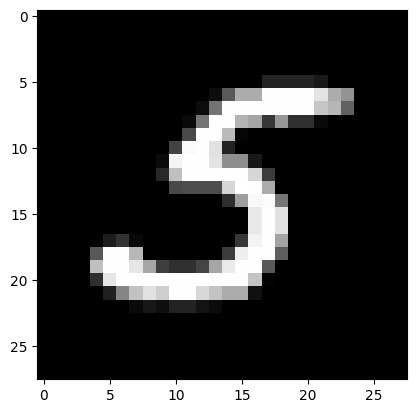

In [ ]:
i = np.random.randint(0, 60000)
#print(i)
print(ytrain[i])
plt.imshow(xtrain[i], cmap='gray');

In [ ]:
xtrain = (xtrain - 127.5) / 127.5

In [ ]:
print(f'MAX= {xtrain.max()} Min= {xtrain.min()}')

MAX= 1.0 Min= -1.0


128


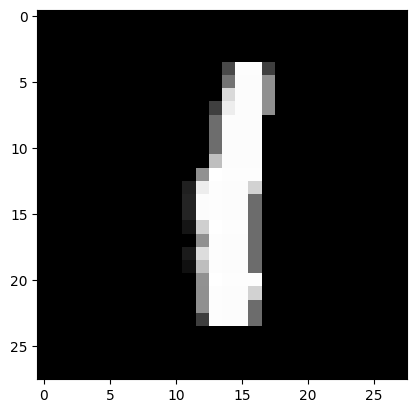

In [ ]:
#plot
i=np.random.randint(0,59999)
print(i)
plt.imshow(xtrain[i],cmap='gray')

In [ ]:
#formateo de las imagenes
xtrain=xtrain.reshape(xtrain.shape[0],28,28,1).astype('float32')
xtest=xtest.reshape(xtest.shape[0],28,28,1).astype('float32')
print(f'{xtrain.shape} , {xtest.shape}')

(60000, 28, 28, 1) , (10000, 28, 28, 1)


In [ ]:
buffer_size=60000
batch_size=256
type(xtrain)

numpy.ndarray

In [ ]:
#formato a data tensorflow
xtrain=tf.data.Dataset.from_tensor_slices(xtrain).shuffle(buffer_size).batch(batch_size)
print(xtrain)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [ ]:
def build_generator():
  network = Sequential()

  network.add(Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(BatchNormalization())
  network.add(LeakyReLU())

  network.add(Reshape((7,7,256)))

  # 7x7x128
  network.add(Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(BatchNormalization())
  network.add(LeakyReLU())

  # 14x14x64
  network.add(Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(BatchNormalization())
  network.add(LeakyReLU())

  # 28x28x1
  network.add(Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network



In [ ]:
generator=build_generator()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 128)        

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_6_input')>

In [ ]:
noise=tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.3775641 ,  0.23744339, -0.63093483, -0.5907403 , -1.5671787 ,
        -0.95258313, -0.40408826,  0.74812645,  0.4330065 ,  0.8554809 ,
         1.2220839 ,  0.22742145, -0.77788645,  0.16075185, -1.8408017 ,
         1.0013579 , -0.65995   , -0.8991898 ,  0.3682601 , -2.9086325 ,
         1.5905703 ,  0.31408232,  0.27451655,  0.93149763, -0.39127663,
         1.1971323 , -0.02308872,  0.9929079 ,  1.5606085 , -1.0257885 ,
        -0.15057857, -0.5998185 , -0.13964345,  0.61153585,  0.4616685 ,
         1.8401598 ,  0.3030593 ,  1.5355282 , -0.04050638, -0.7031011 ,
        -0.2984985 , -1.1568152 , -2.1952658 ,  0.6494767 ,  3.2642913 ,
         0.20630936,  0.8791318 ,  1.2545464 , -0.37331903,  0.0240467 ,
        -0.05449112, -0.9577874 ,  0.14428668,  1.0286292 , -0.05957953,
        -2.0687373 ,  0.49054587, -0.5537113 , -0.04637061,  0.15234433,
        -2.5658917 , -0.9709449 , -0.8087734 , -1.4851345 ,  0.2236404 ,
 

In [ ]:
generated_image=generator(noise,training=False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [ ]:
generated_image[0,:,:,0].shape

TensorShape([28, 28])

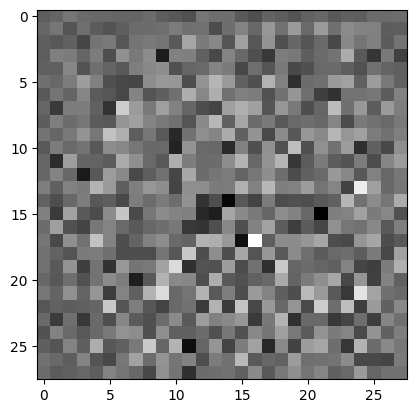

In [ ]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
def build_discriminator():
  network = Sequential()

  # 14x14x64
  network.add(Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(LeakyReLU())
  network.add(Dropout(0.3))

  # 7x7x128
  network.add(Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(LeakyReLU())
  network.add(Dropout(0.3))

  network.add(Flatten())
  network.add(Dense(1))

  network.summary()

  return network


In [ ]:
discriminator=build_discriminator()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)             

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_8_input')>

In [ ]:
discriminator(generated_image,training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00144177]], dtype=float32)>

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(expected_output,fake_output):

  real_loss=cross_entropy(tf.ones_like(expected_output),expected_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_output

  return total_loss


In [ ]:
def generator_loss(fake_output):

  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
#optimizadores
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
epochs=100
noise_dimension=100
number_of_images=16

In [ ]:
batch_size,noise_dimension

(256, 100)

In [ ]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [ ]:
xtrain

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [ ]:
test_images = tf.random.normal([number_of_images, noise_dimension])

Epoch:  1


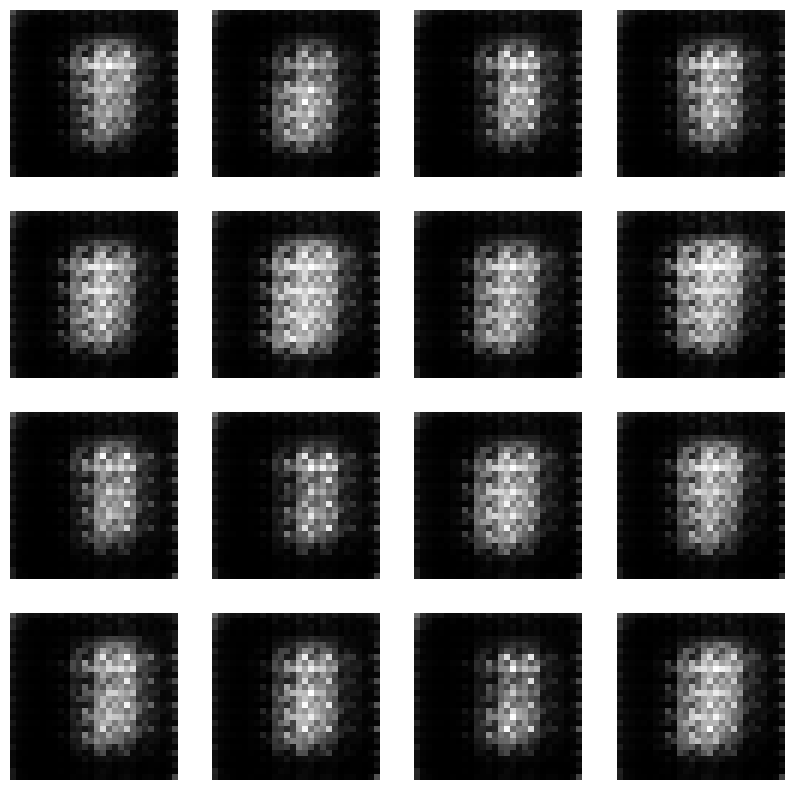

Epoch:  2


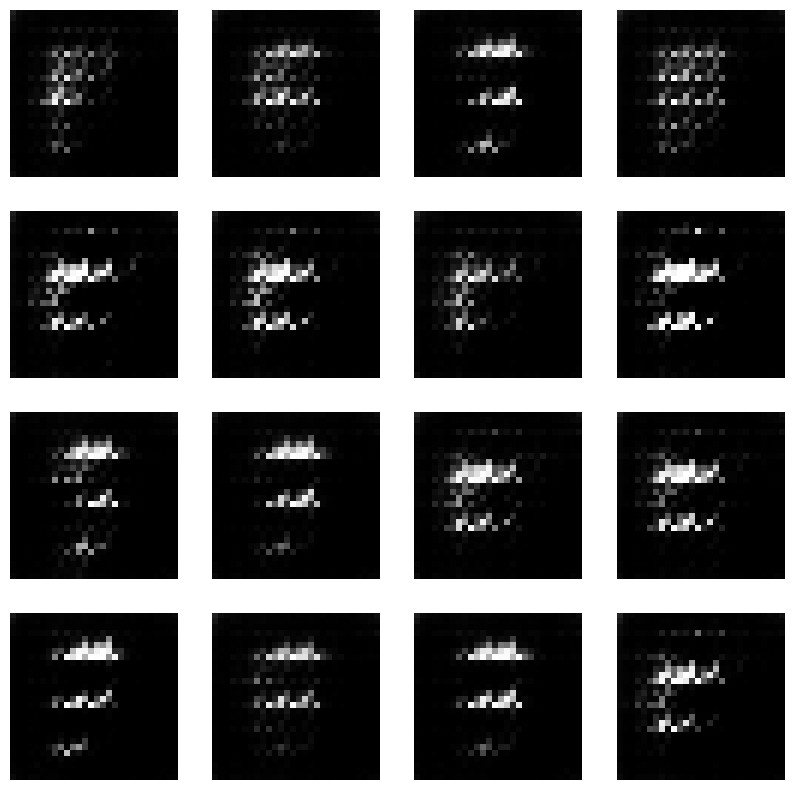

Epoch:  3


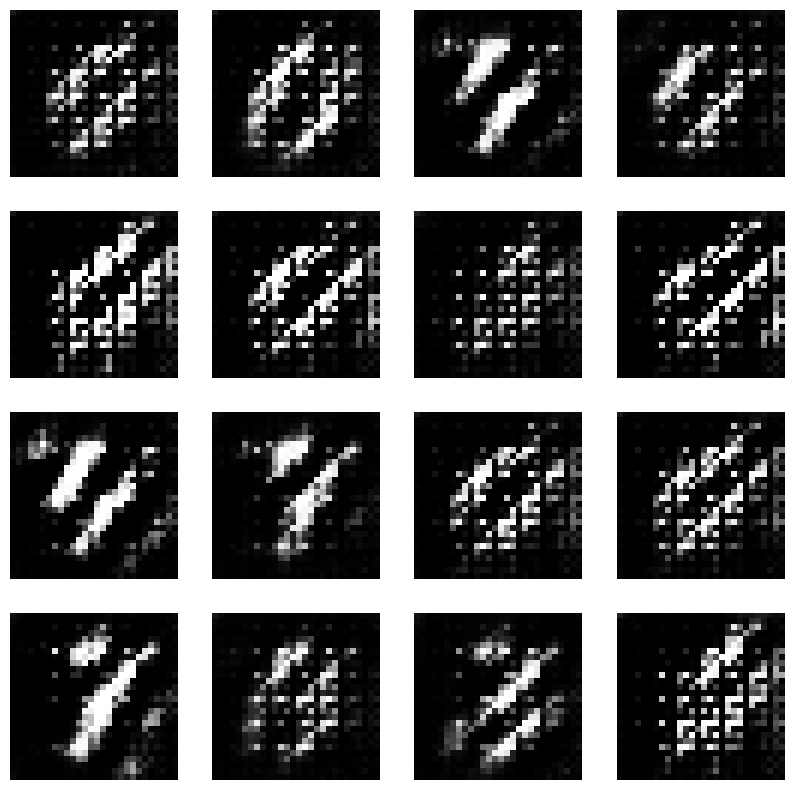

Epoch:  4


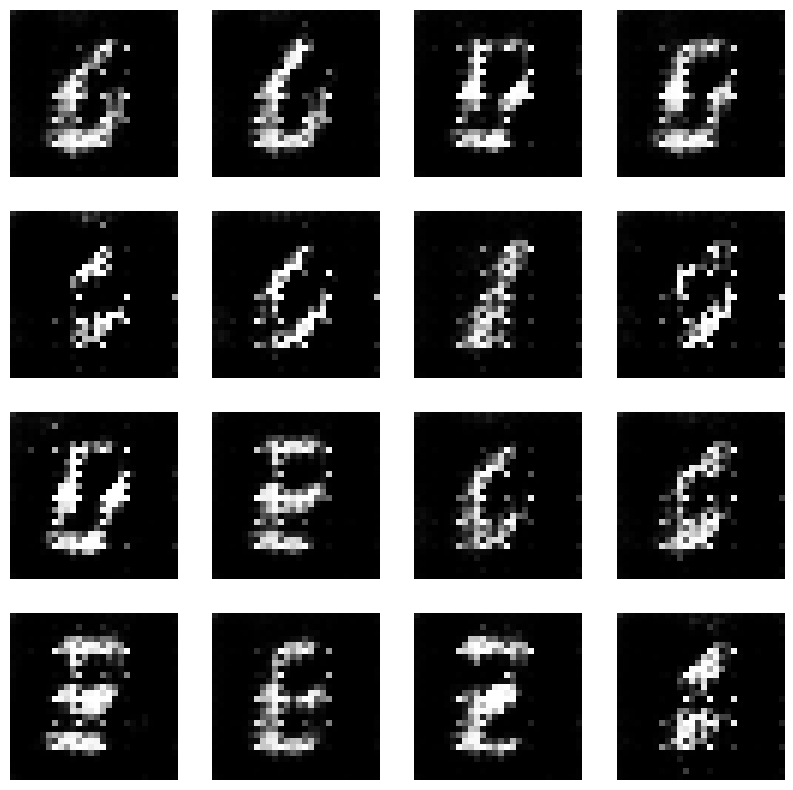

Epoch:  5


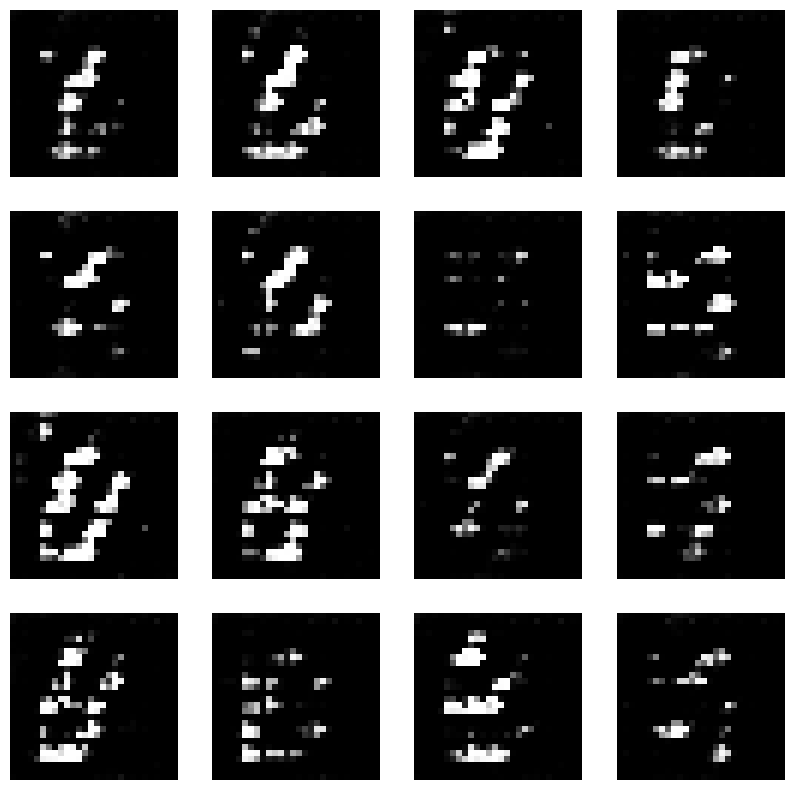

Epoch:  6


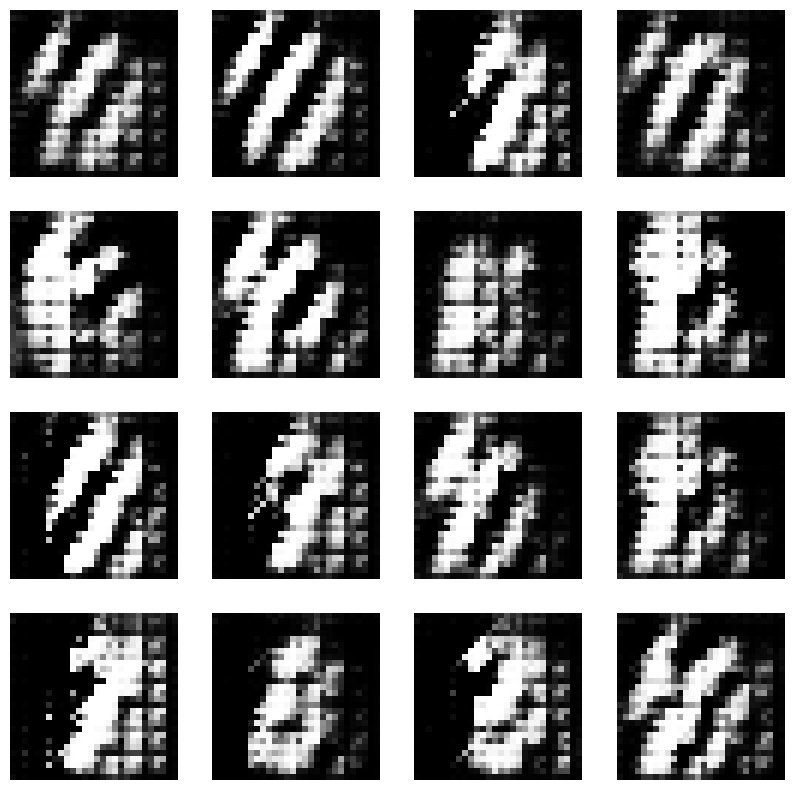

Epoch:  7


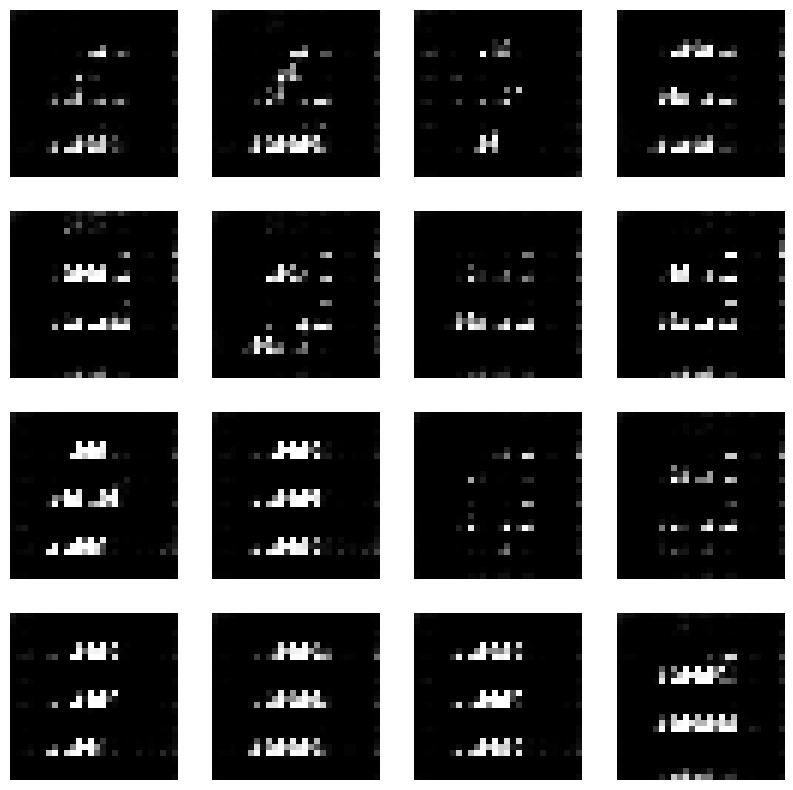

Epoch:  8


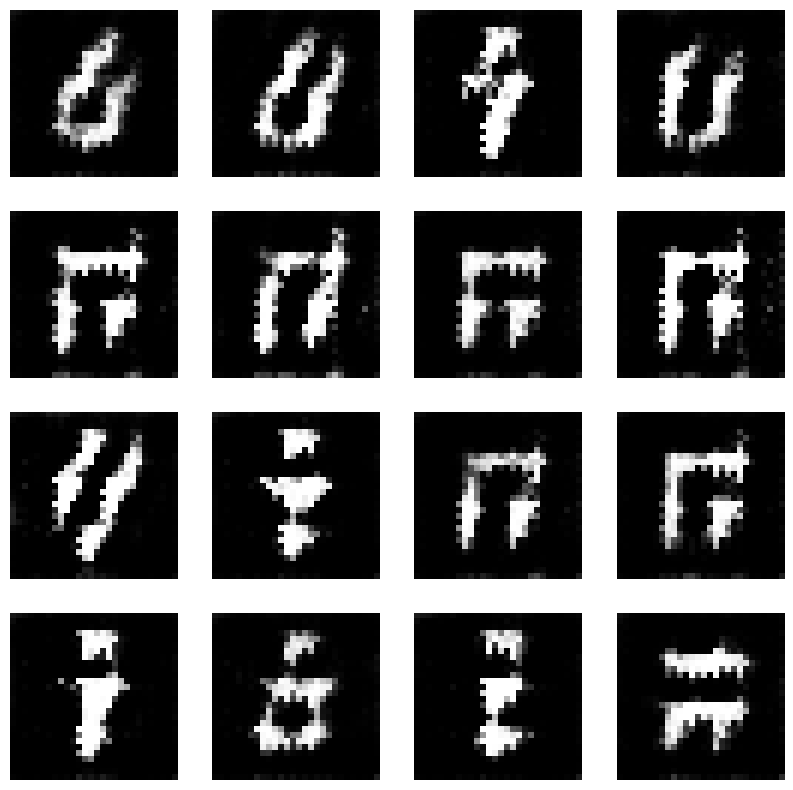

Epoch:  9


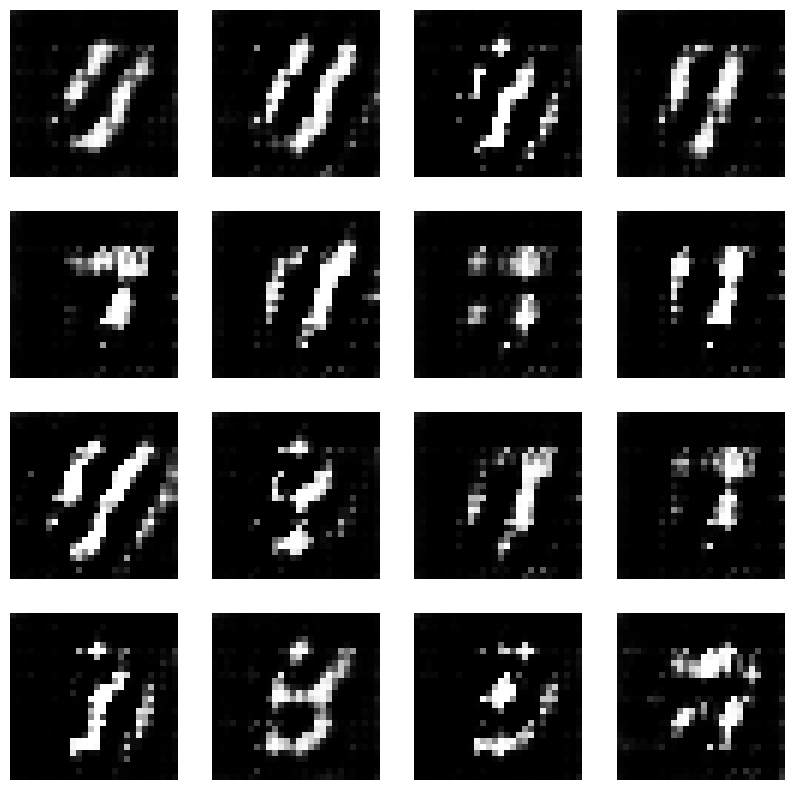

Epoch:  10


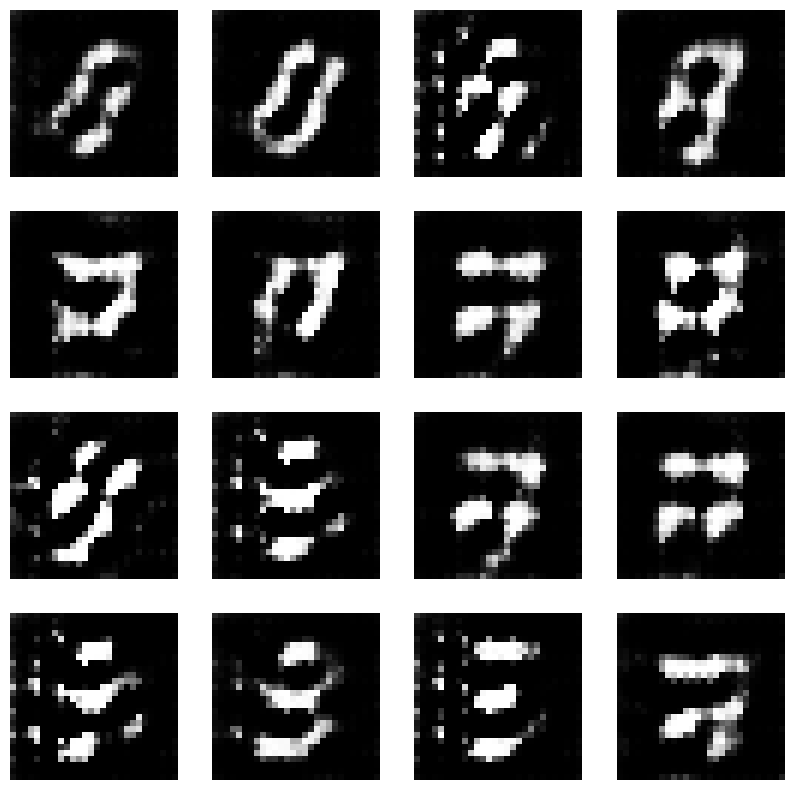

Epoch:  11


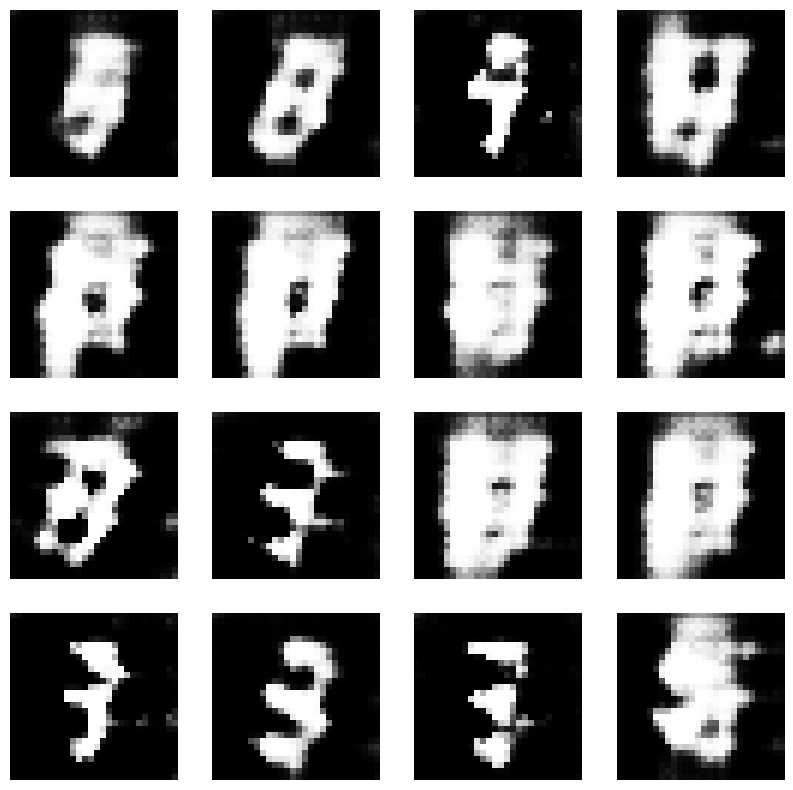

Epoch:  12


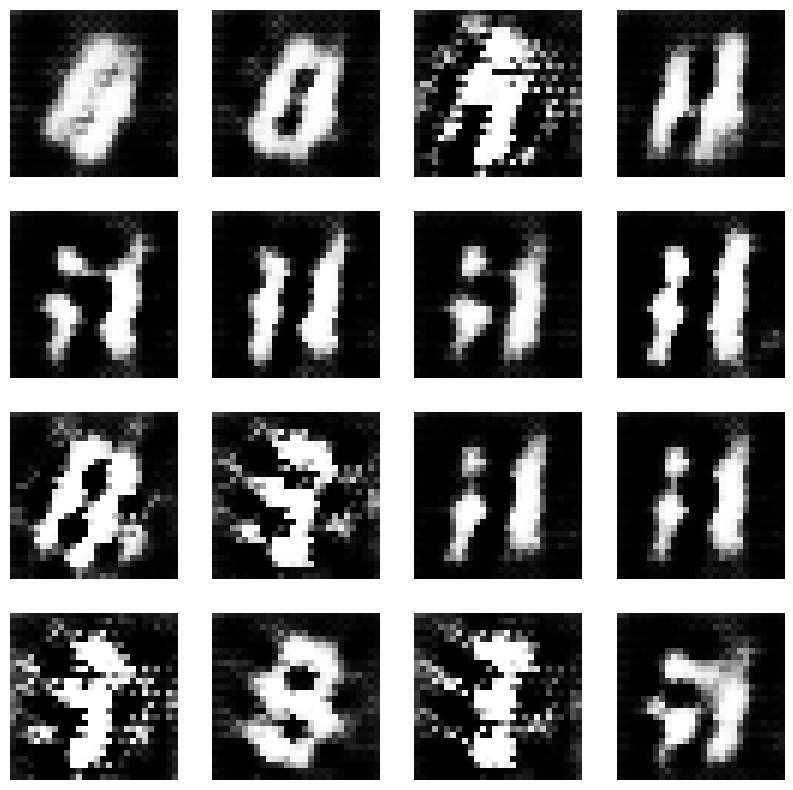

Epoch:  13


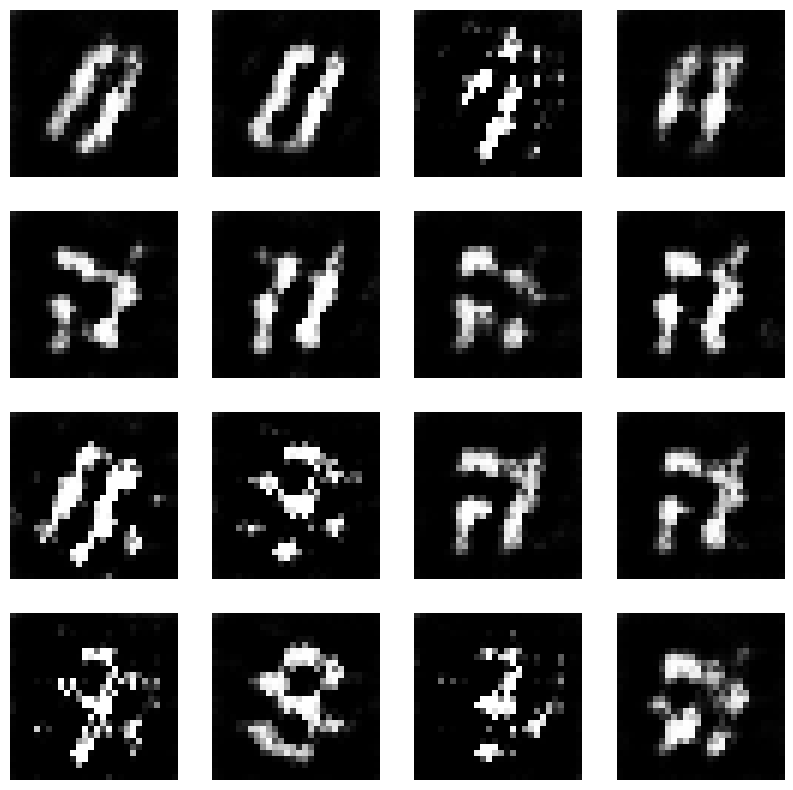

Epoch:  14


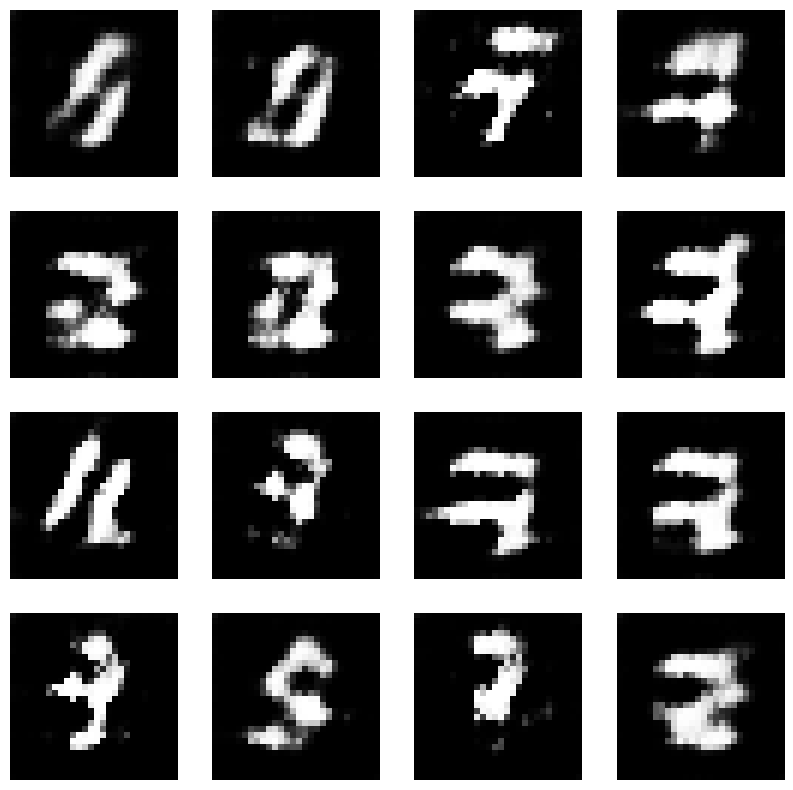

Epoch:  15


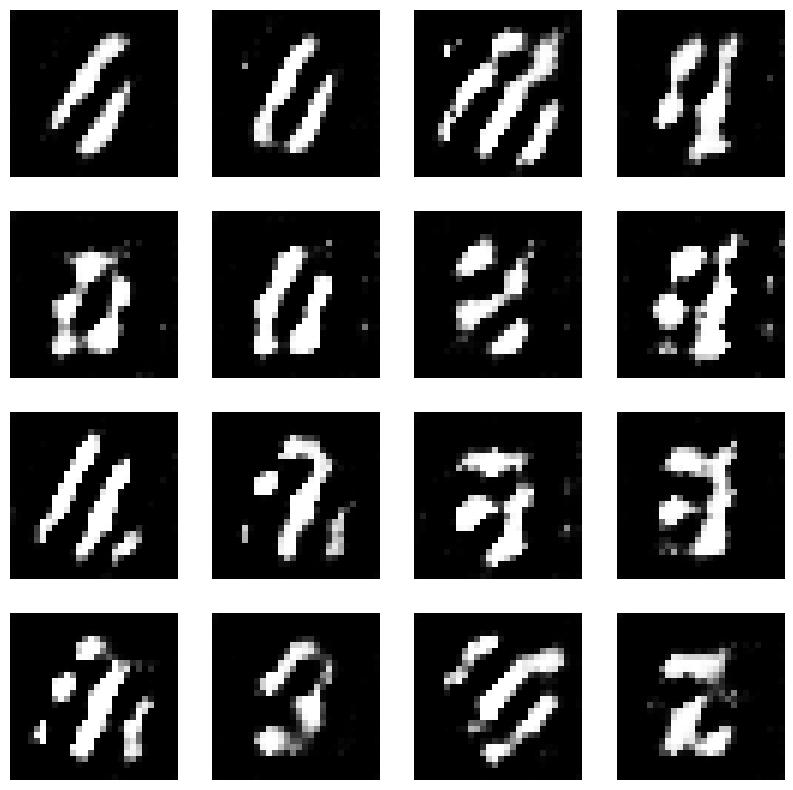

Epoch:  16


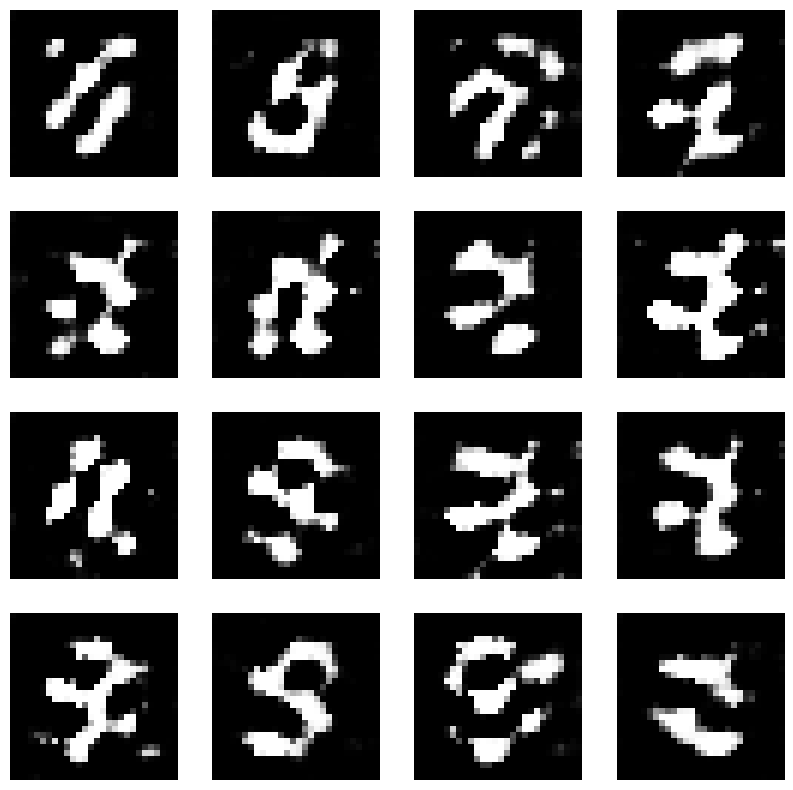

Epoch:  17


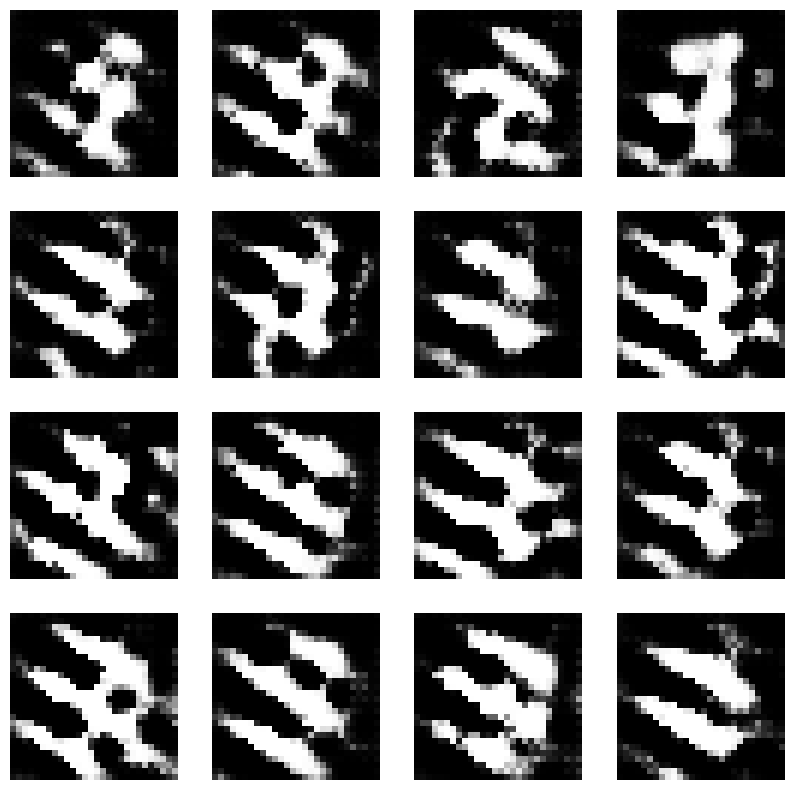

Epoch:  18


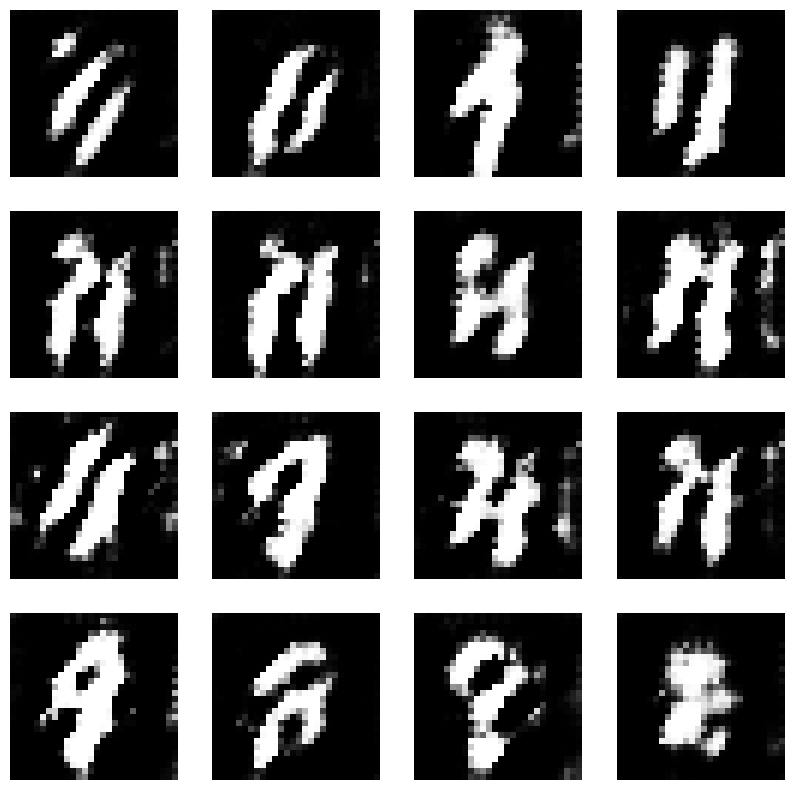

Epoch:  19


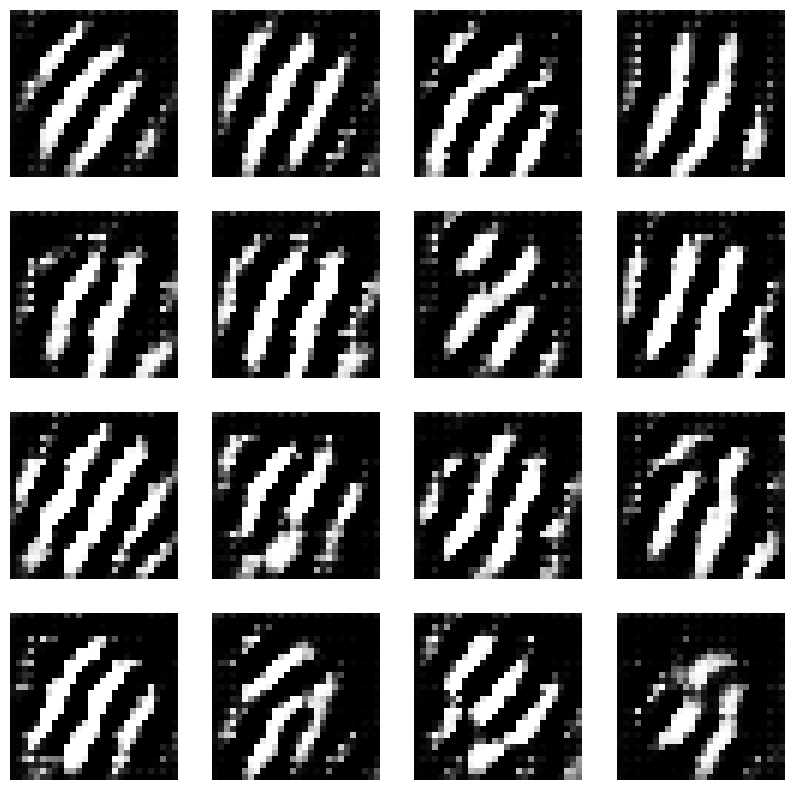

Epoch:  20


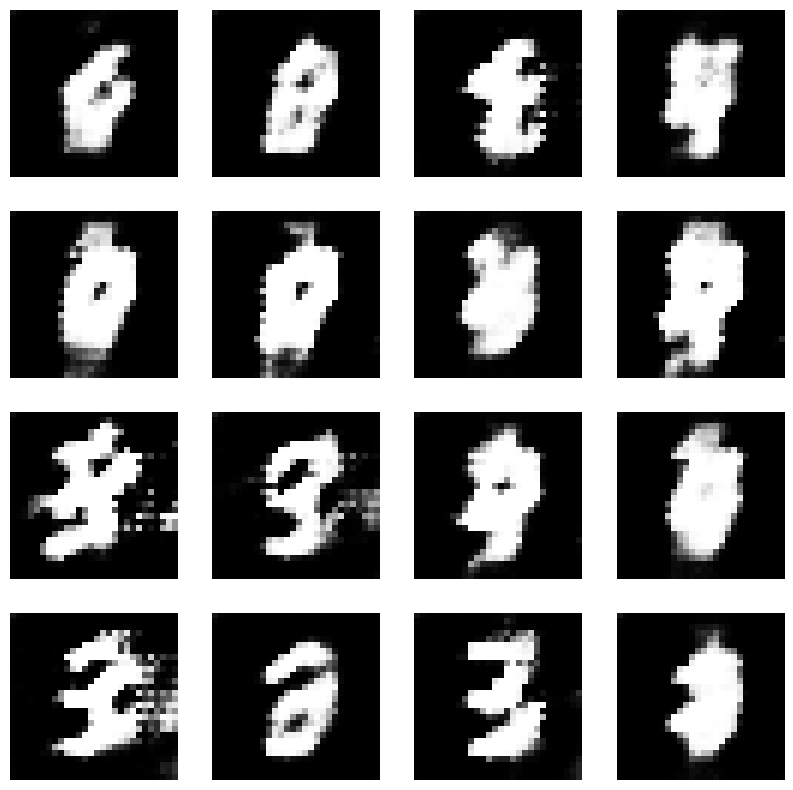

Epoch:  21


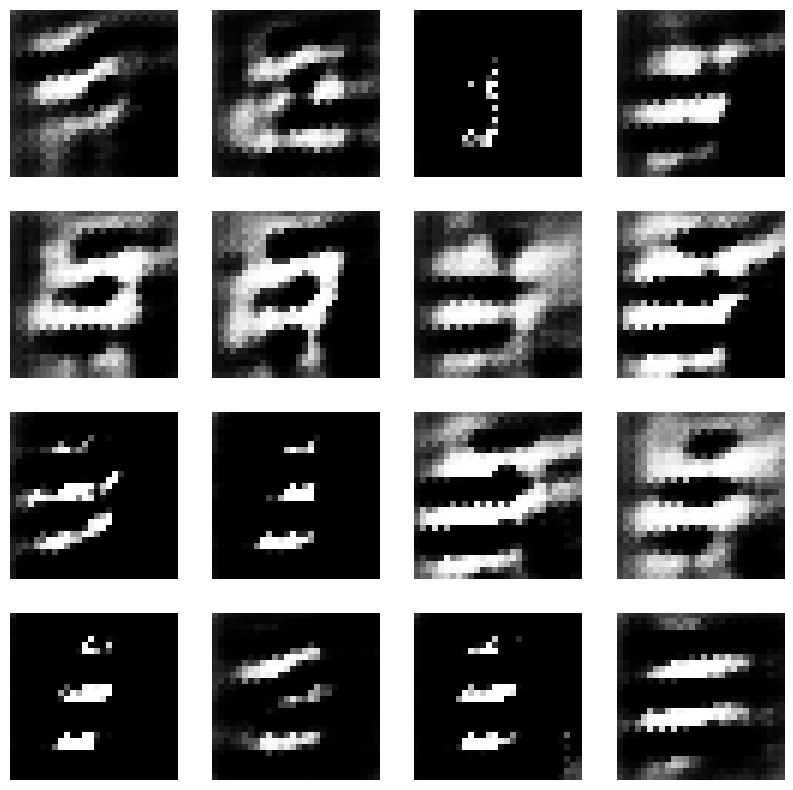

Epoch:  22


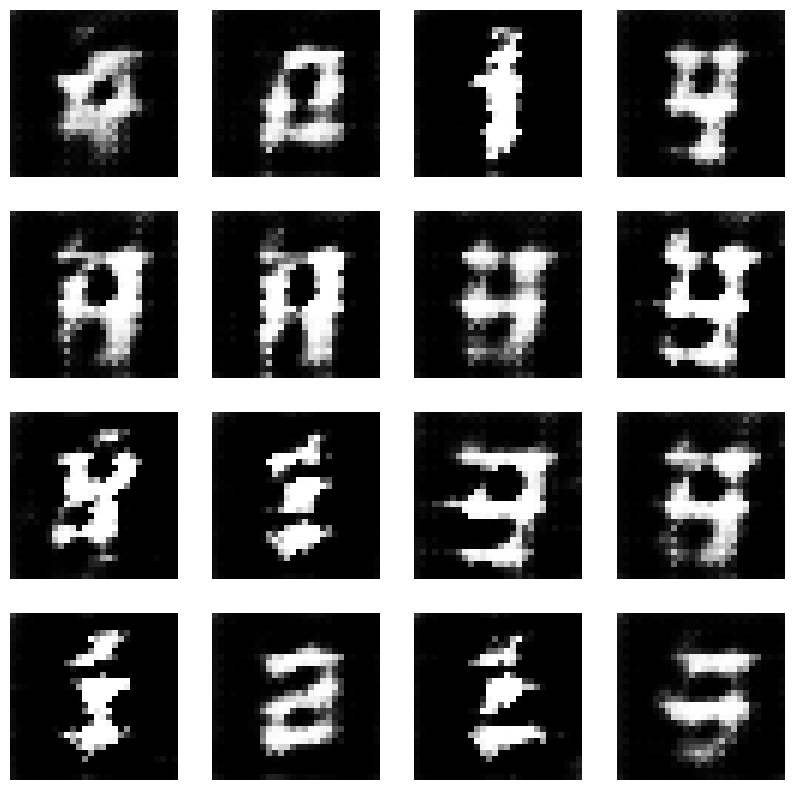

Epoch:  23


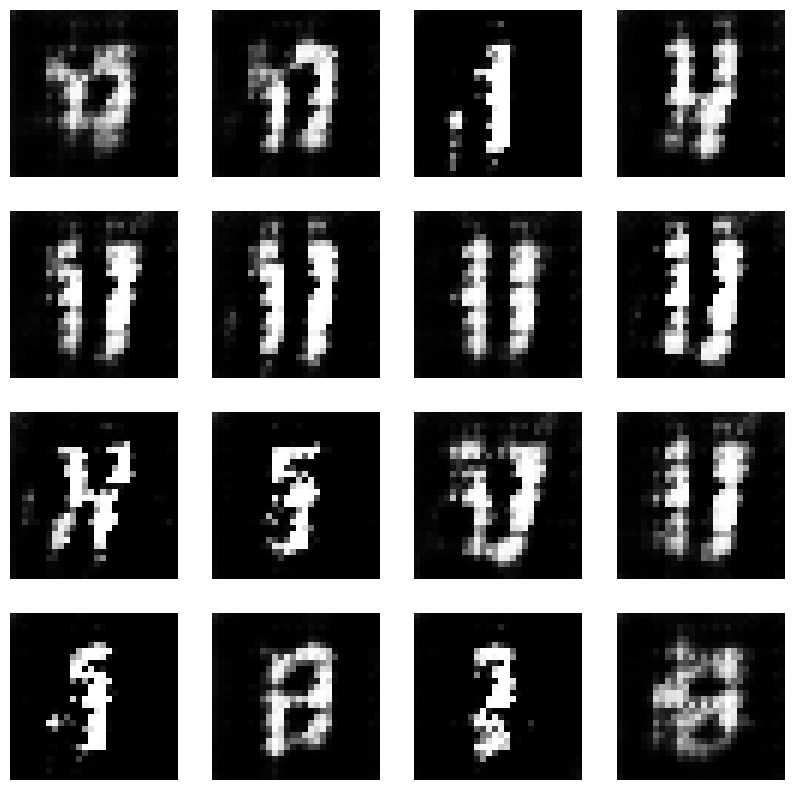

Epoch:  24


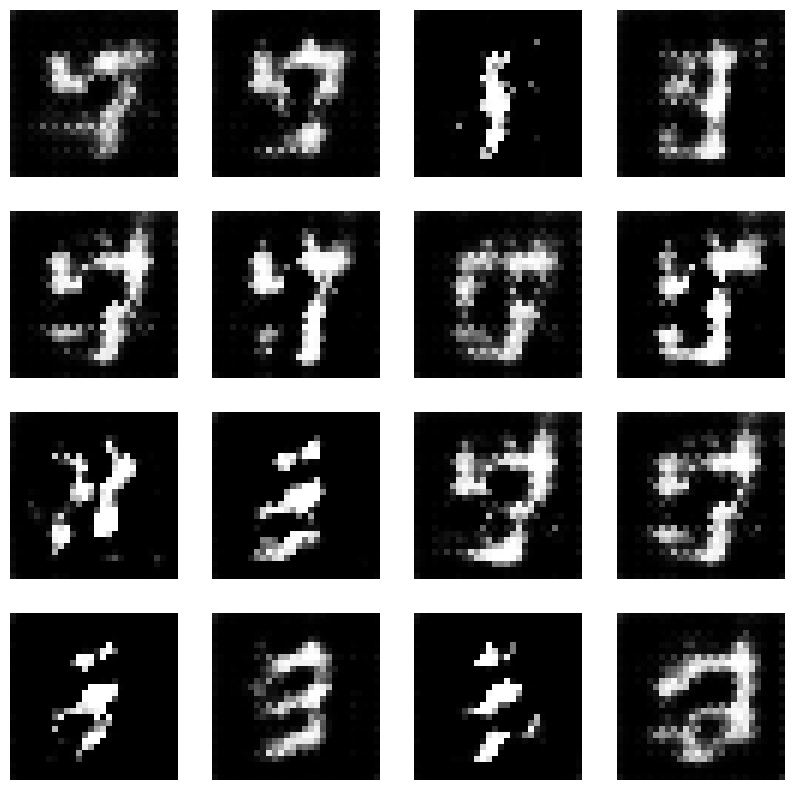

Epoch:  25


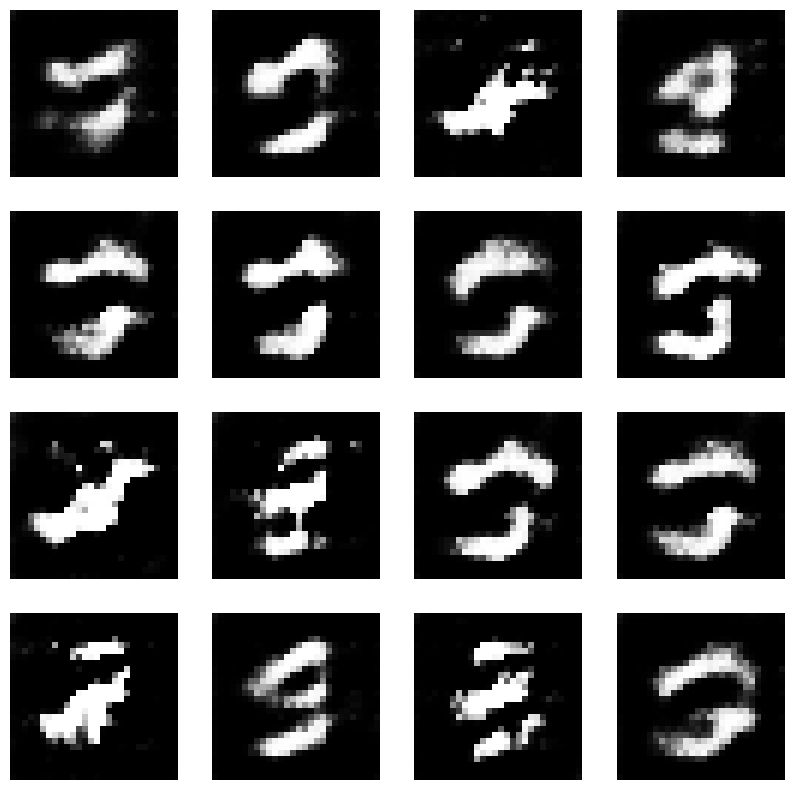

Epoch:  26


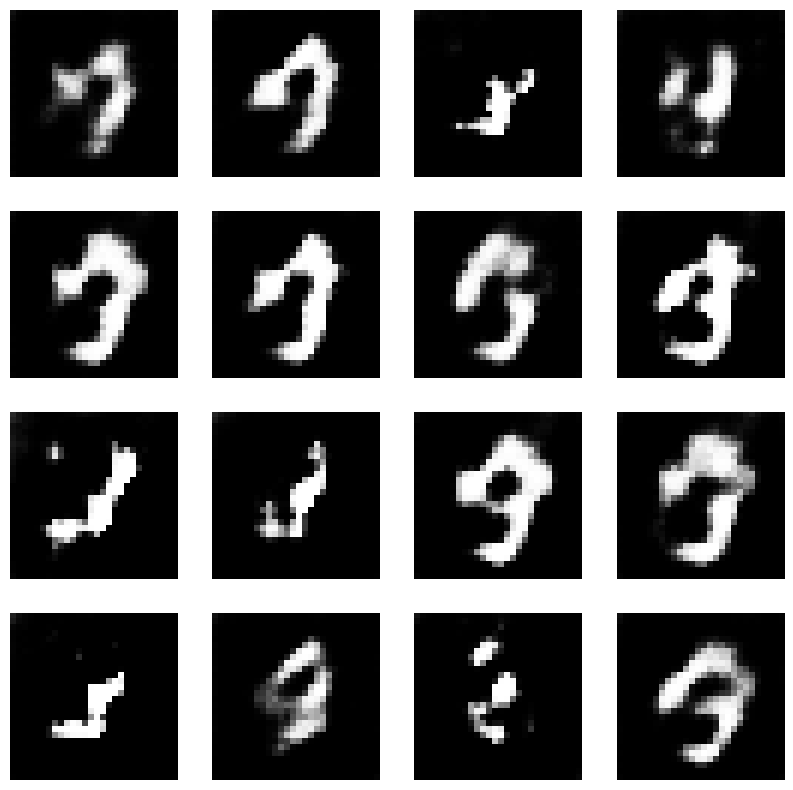

Epoch:  27


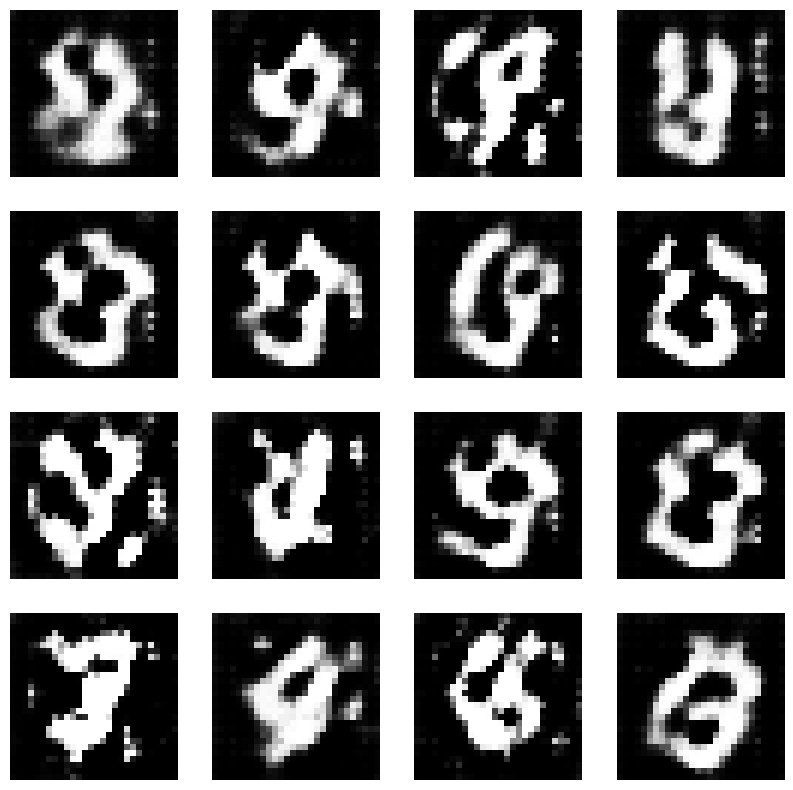

Epoch:  28


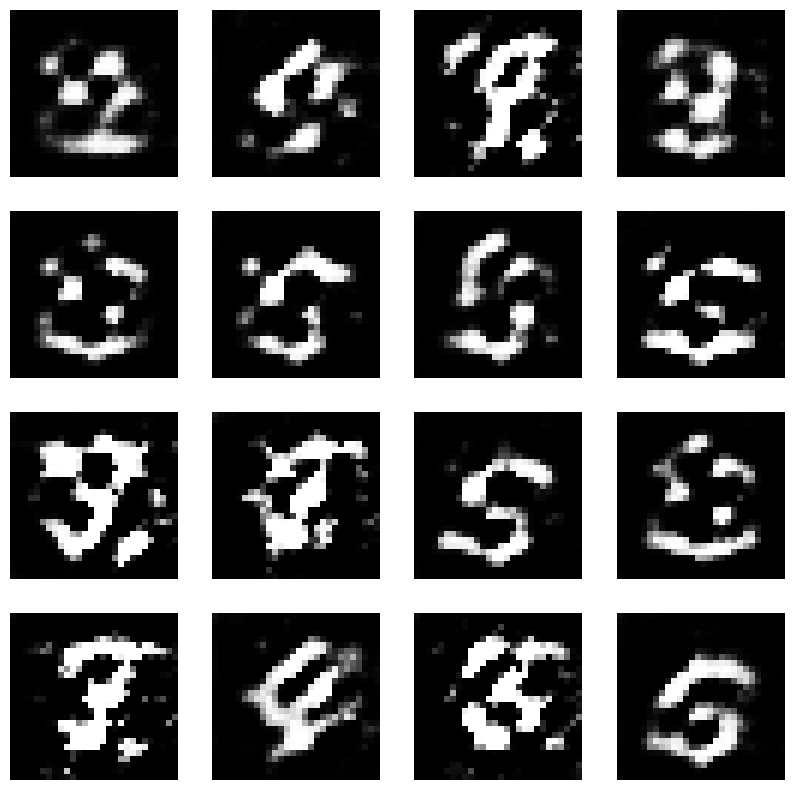

Epoch:  29


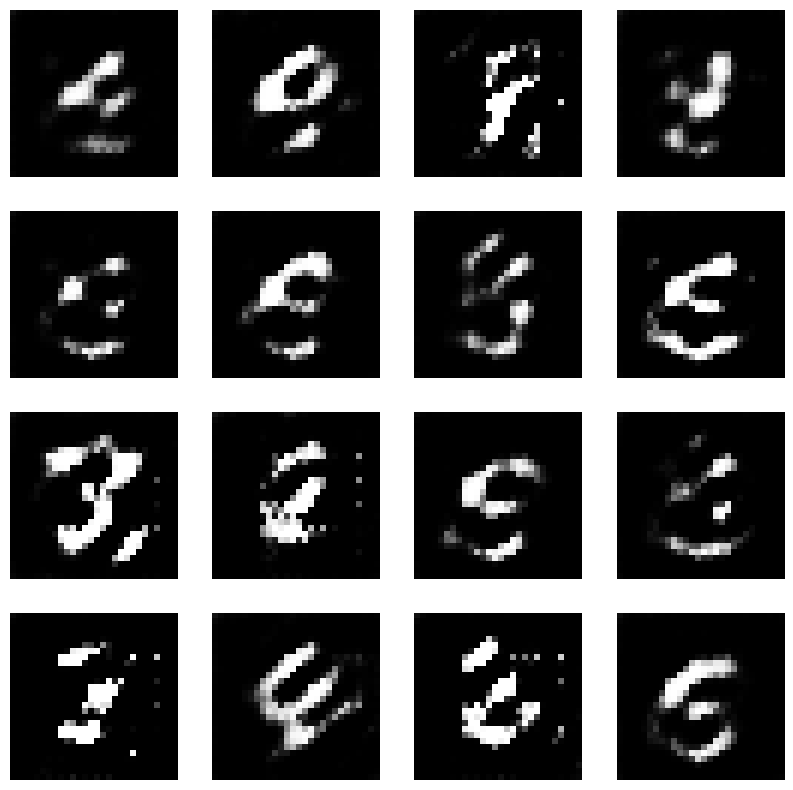

Epoch:  30


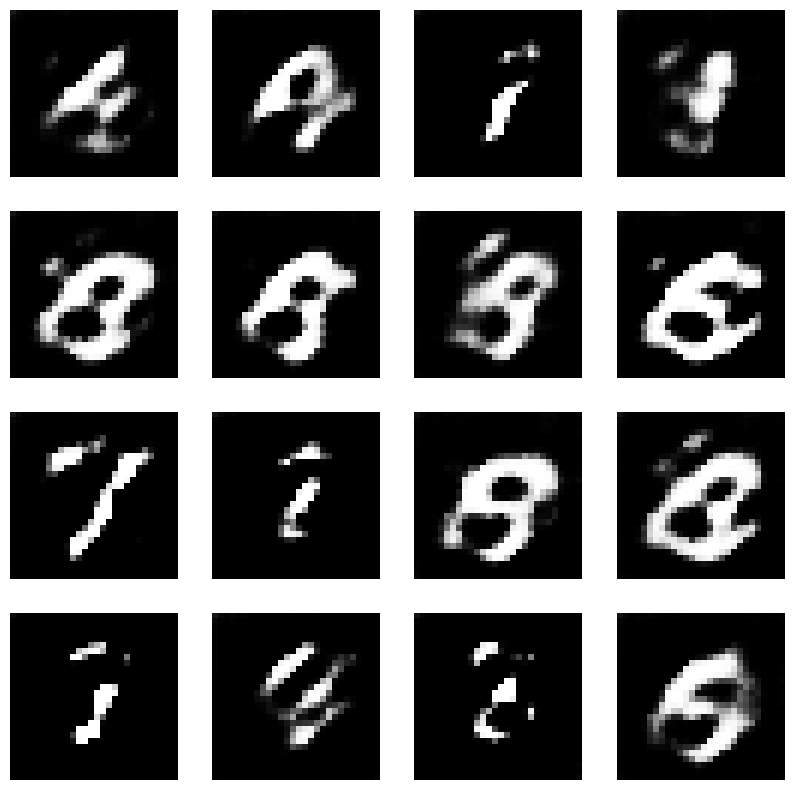

Epoch:  31


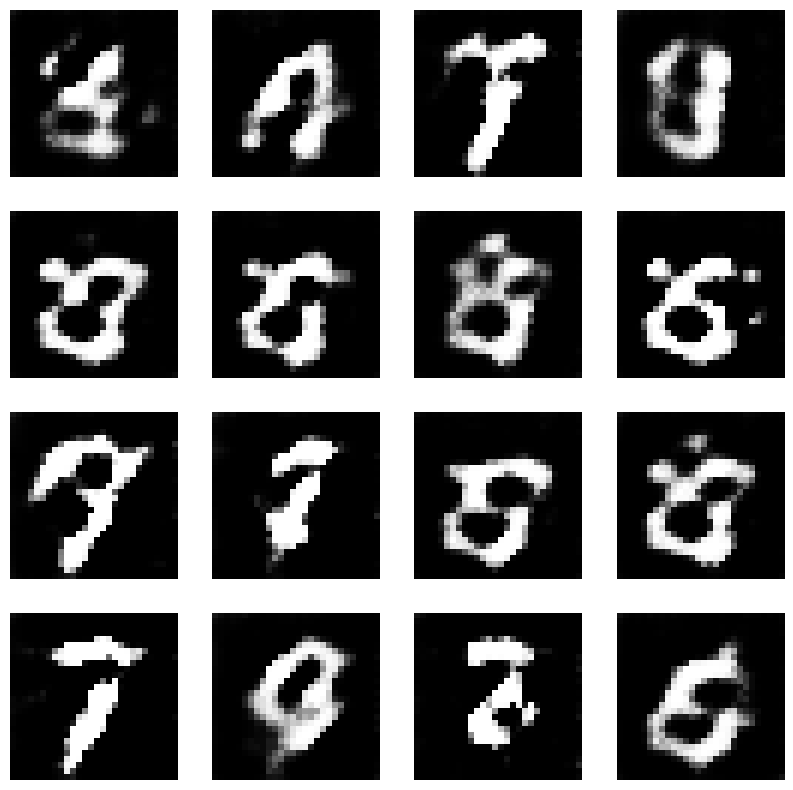

Epoch:  32


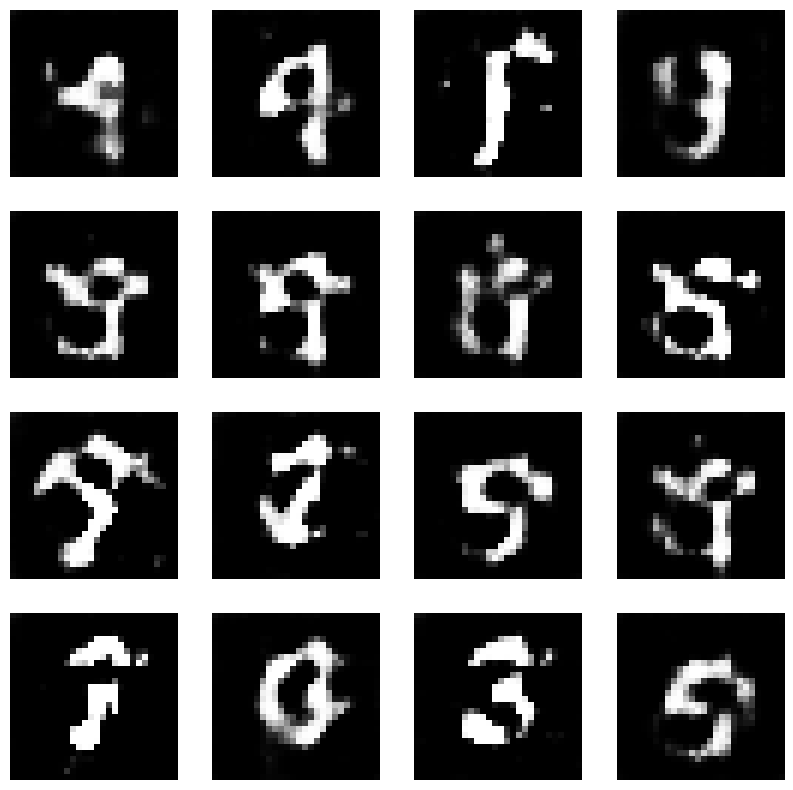

Epoch:  33


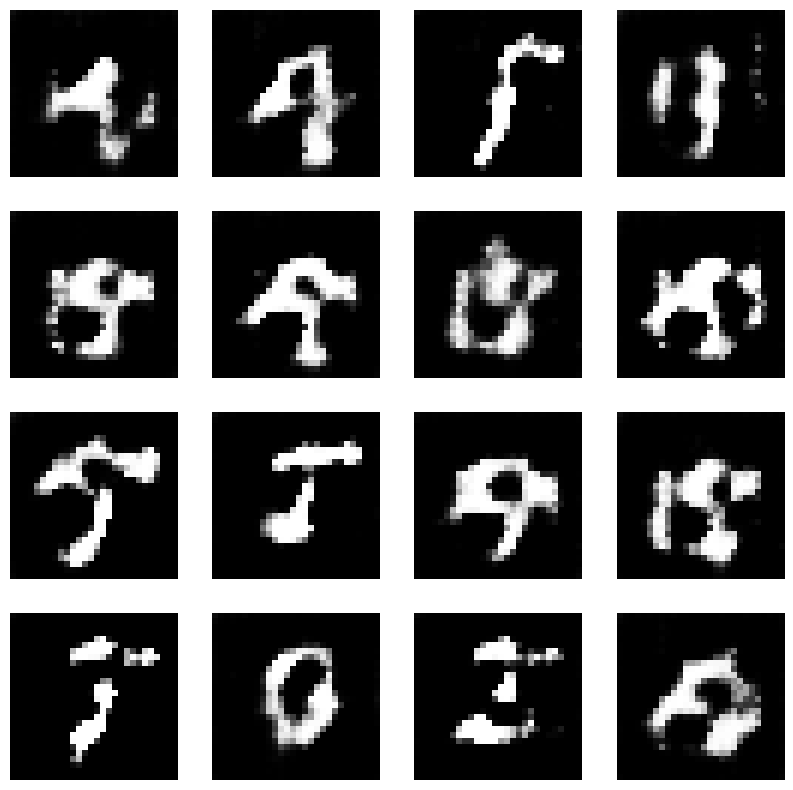

Epoch:  34


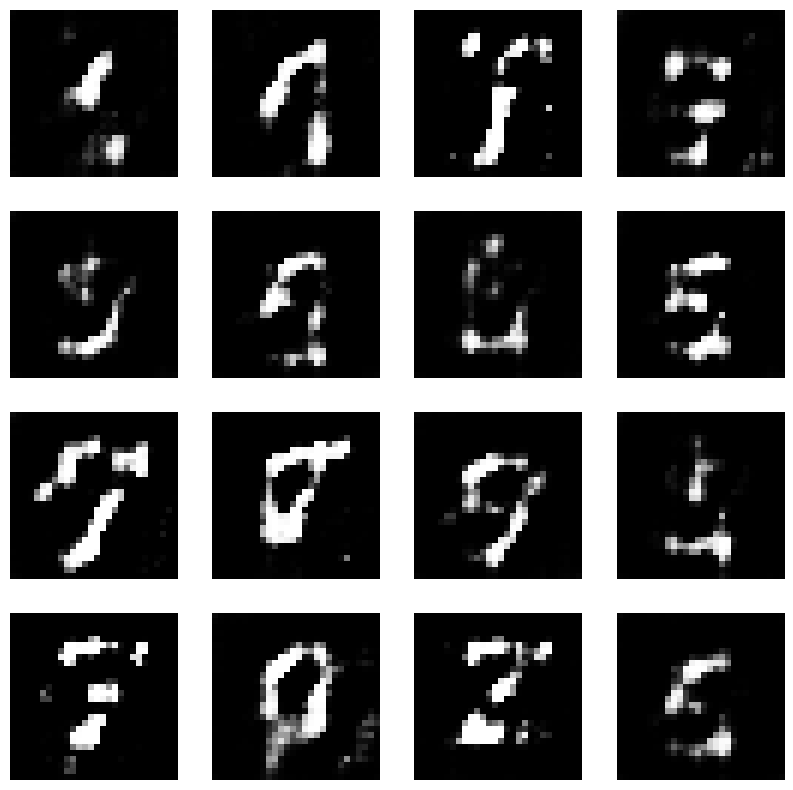

Epoch:  35


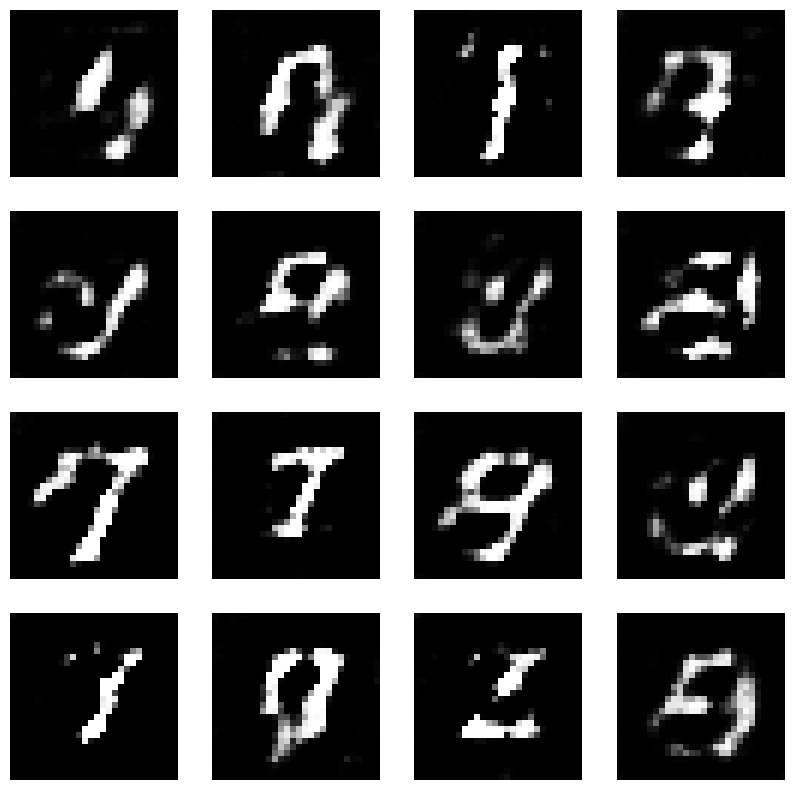

Epoch:  36


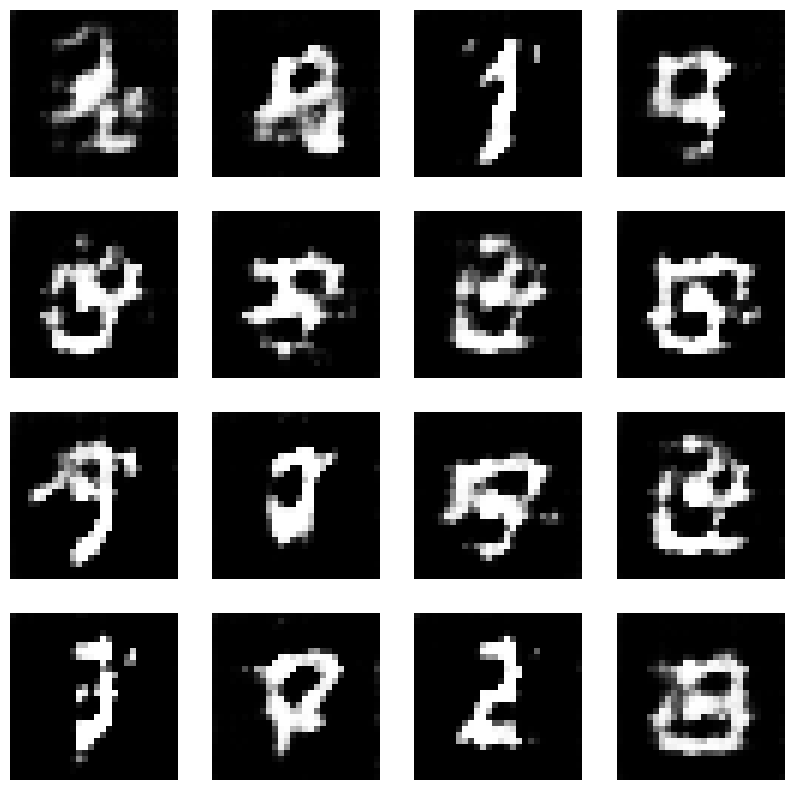

Epoch:  37


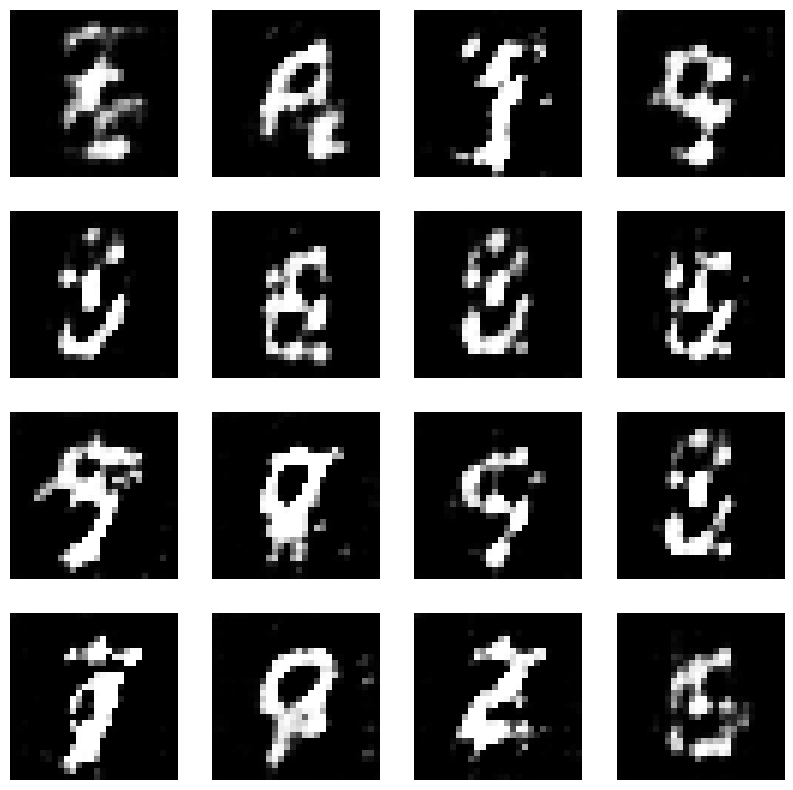

Epoch:  38


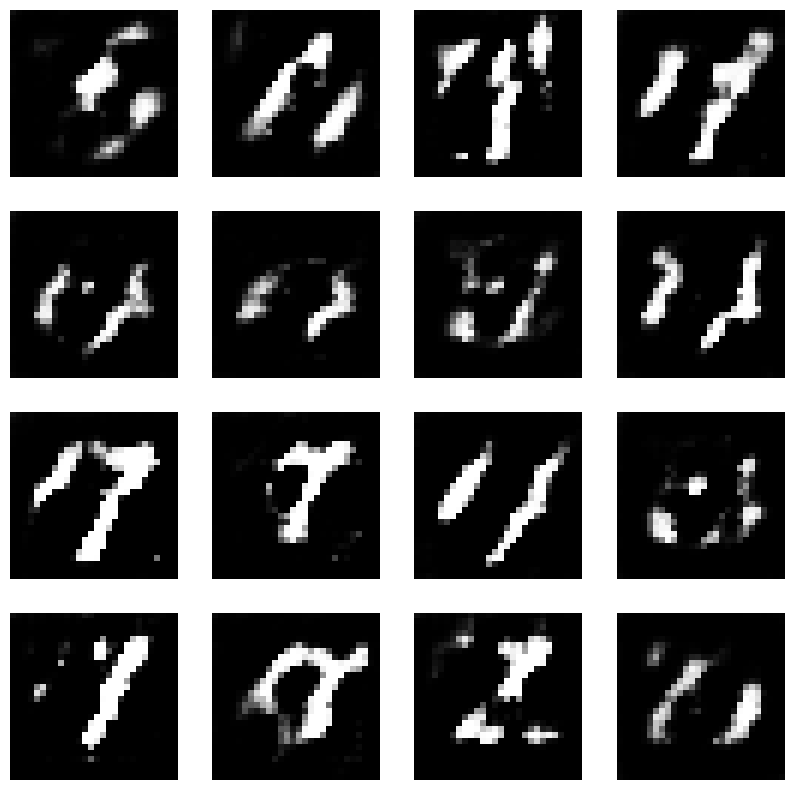

Epoch:  39


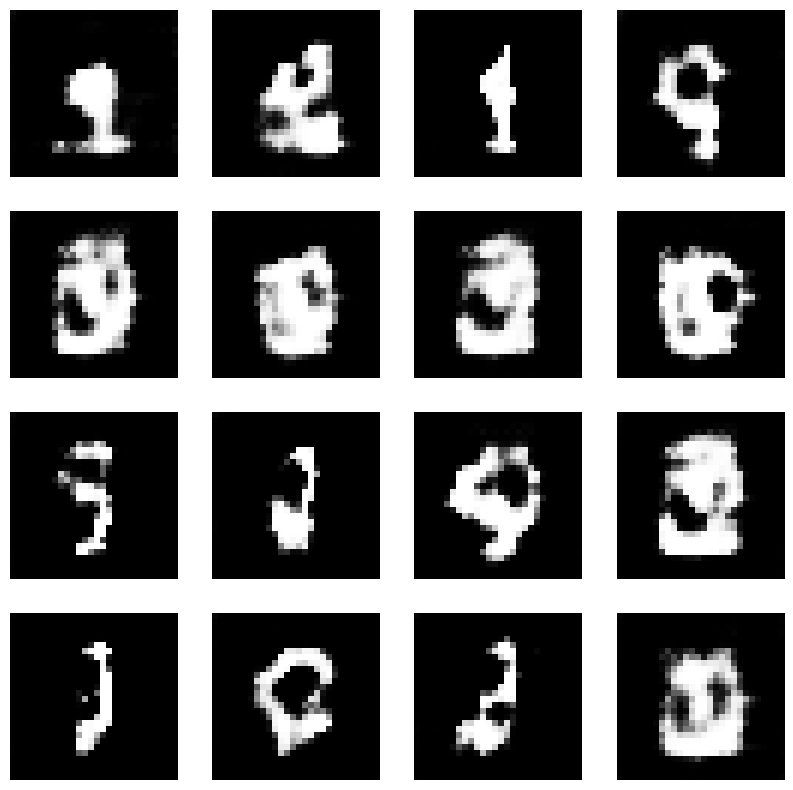

Epoch:  40


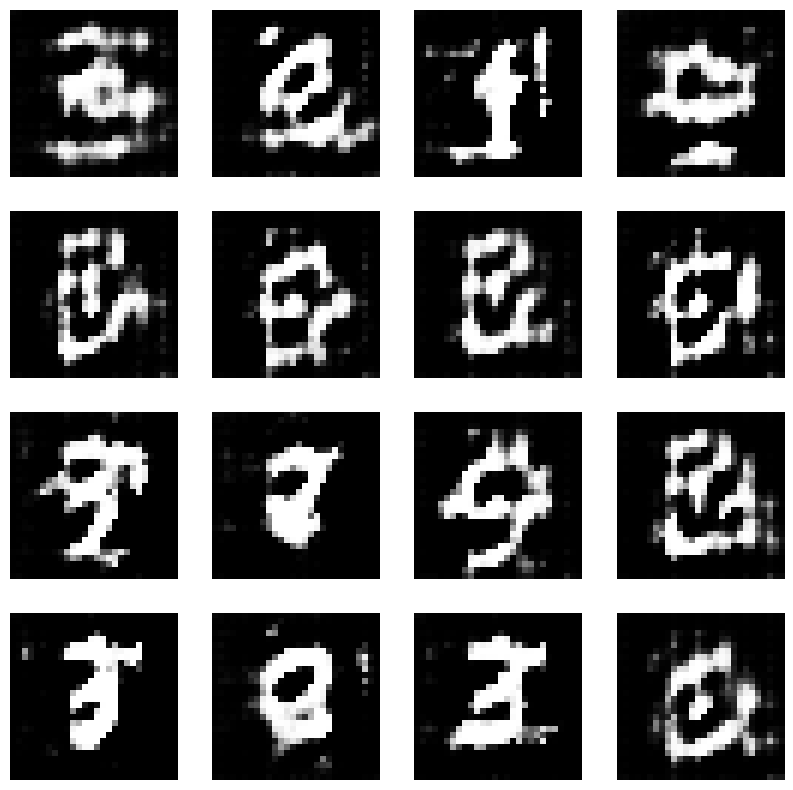

Epoch:  41


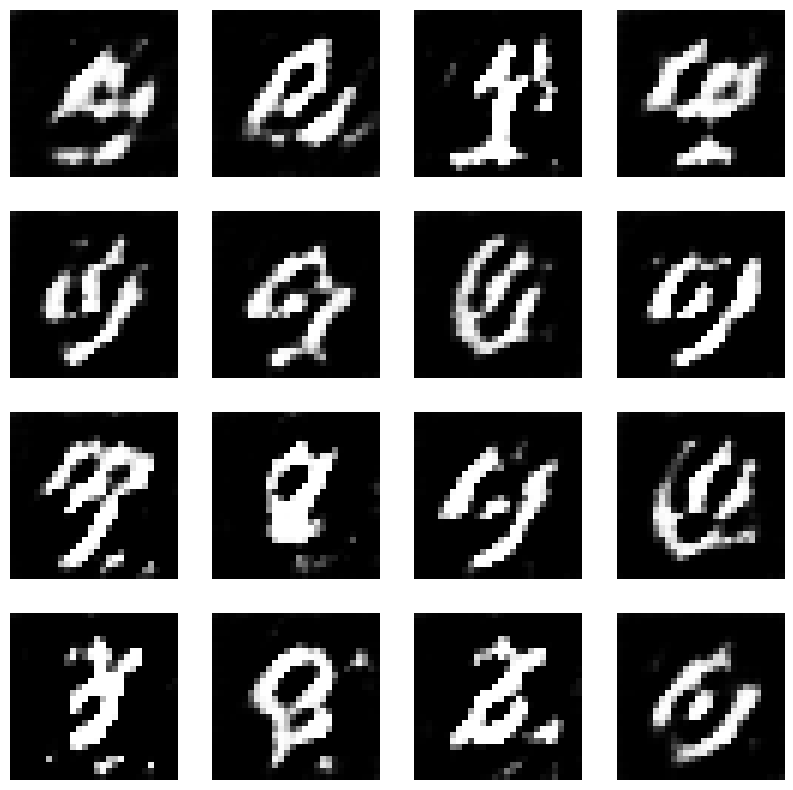

Epoch:  42


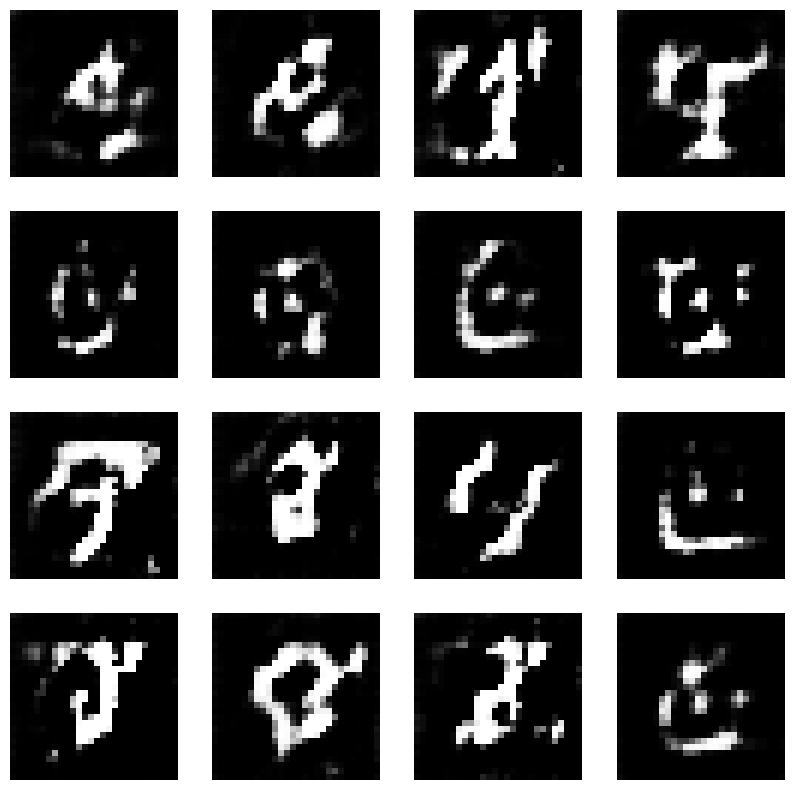

Epoch:  43


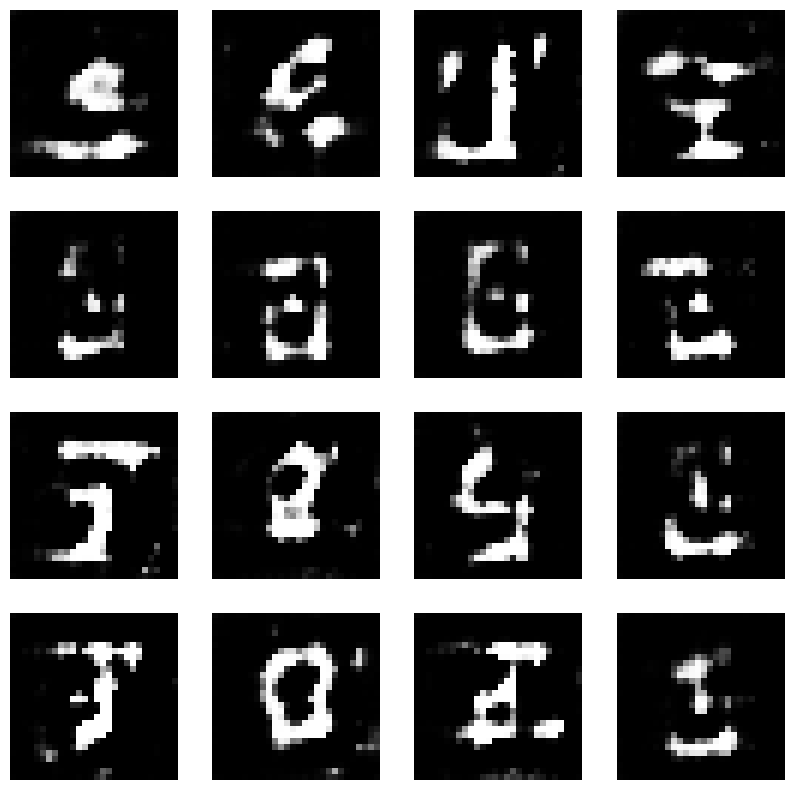

Epoch:  44


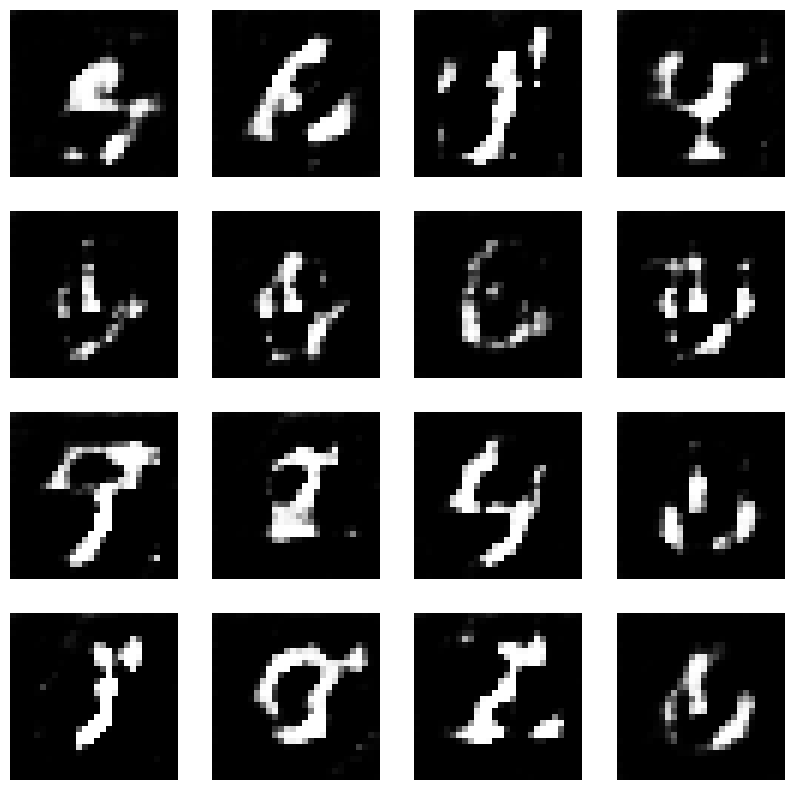

Epoch:  45


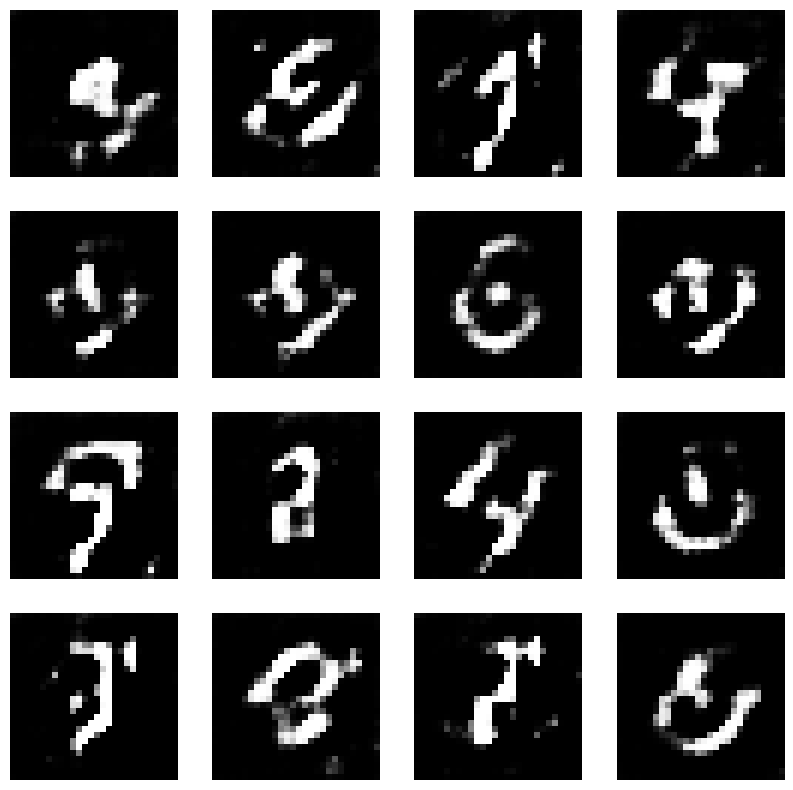

Epoch:  46


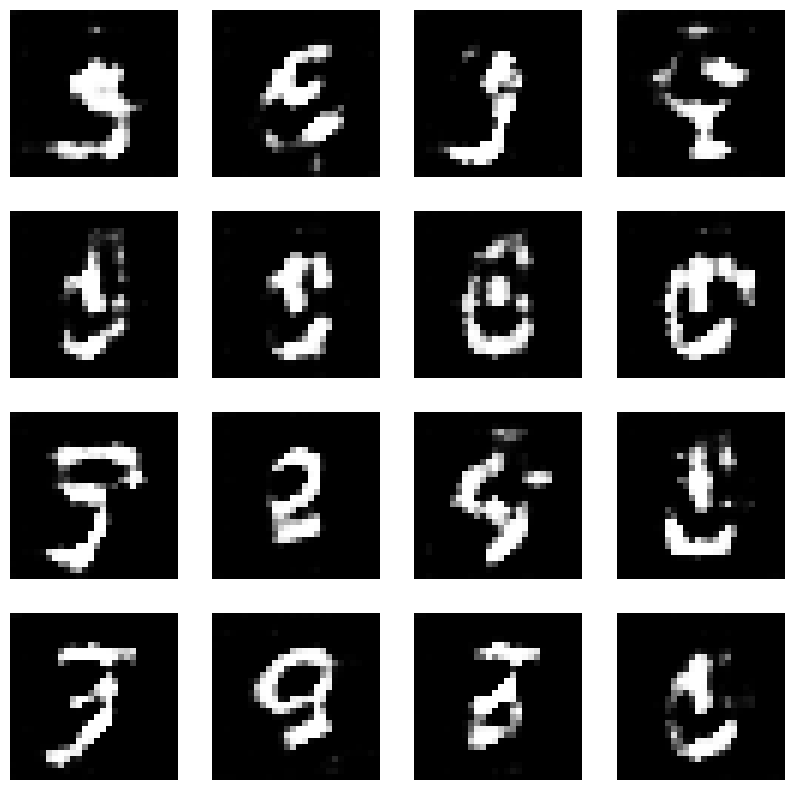

Epoch:  47


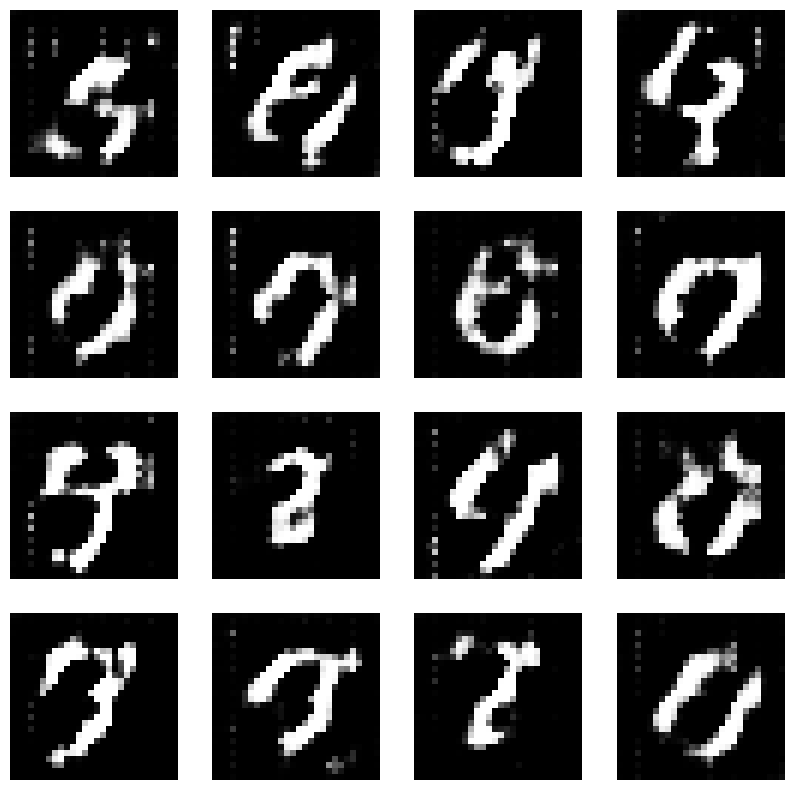

Epoch:  48


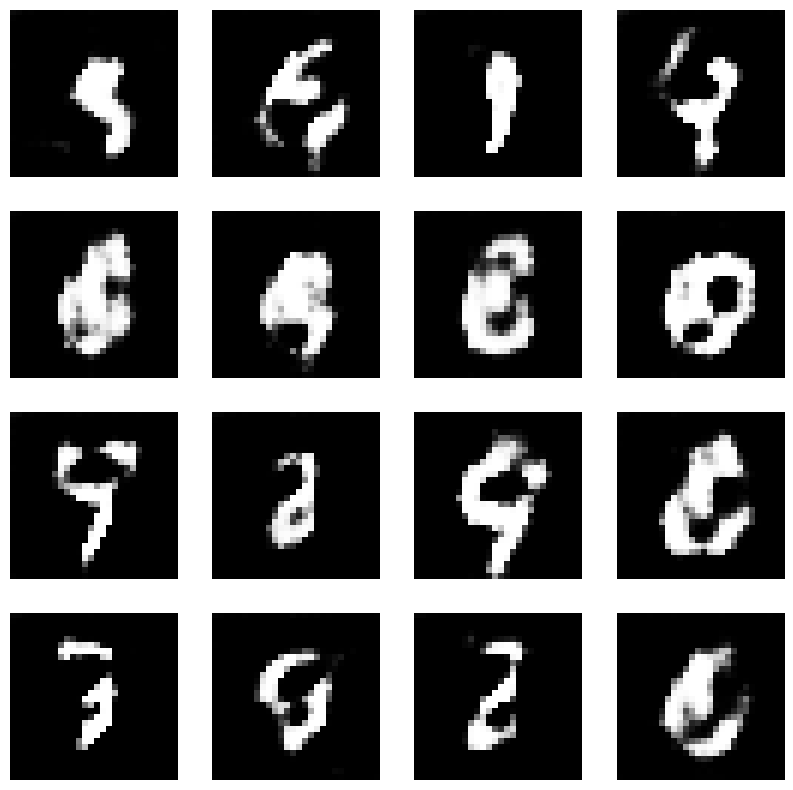

Epoch:  49


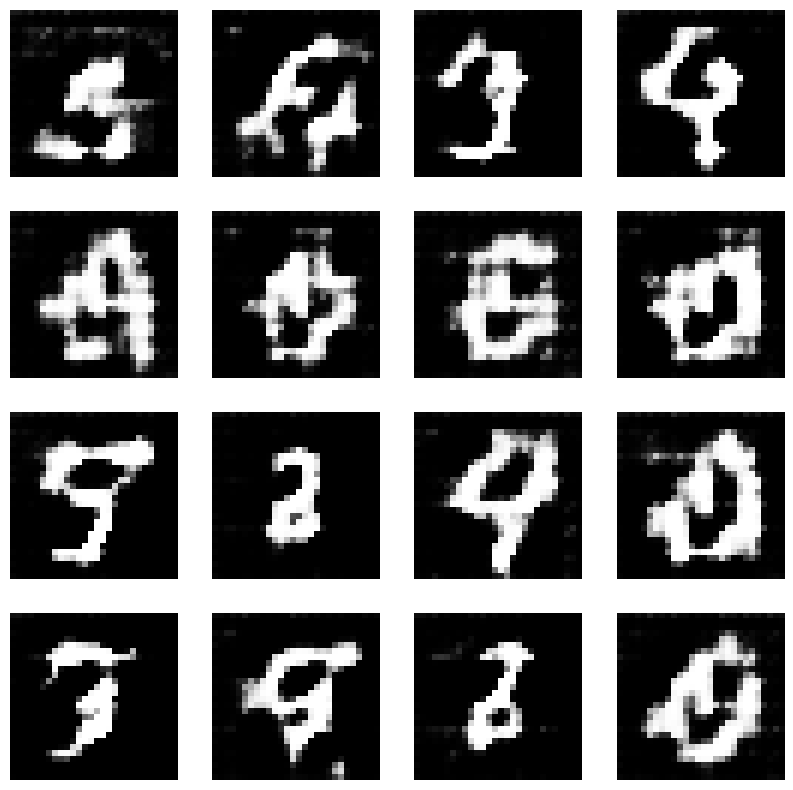

Epoch:  50


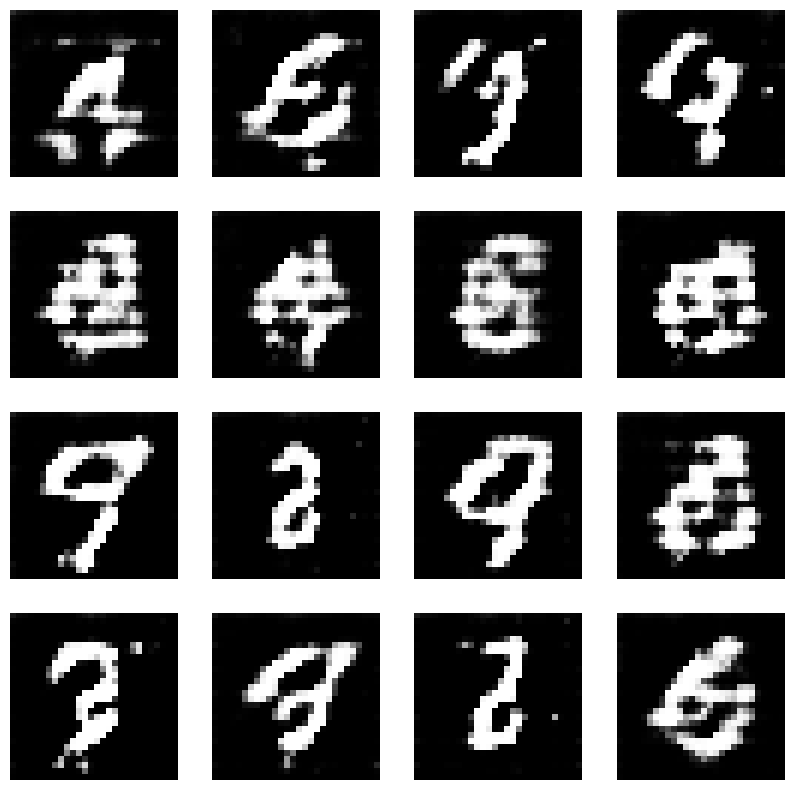

Epoch:  51


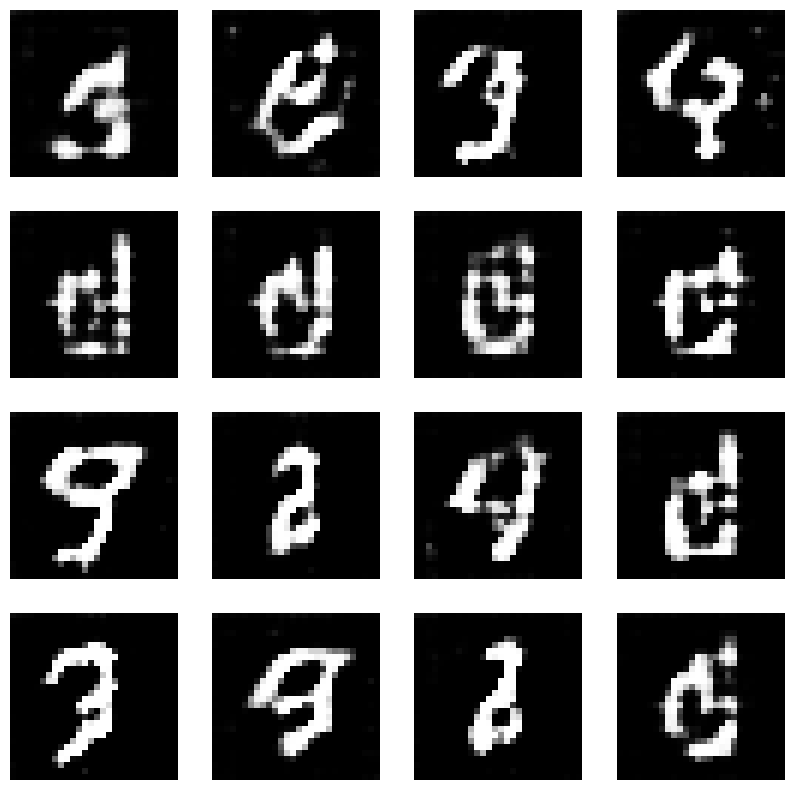

Epoch:  52


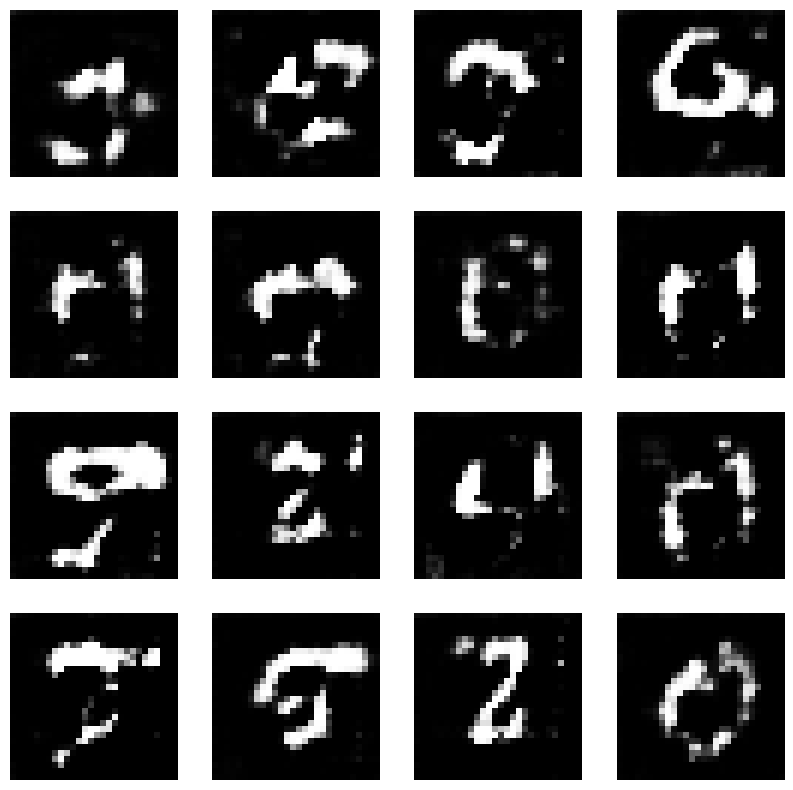

Epoch:  53


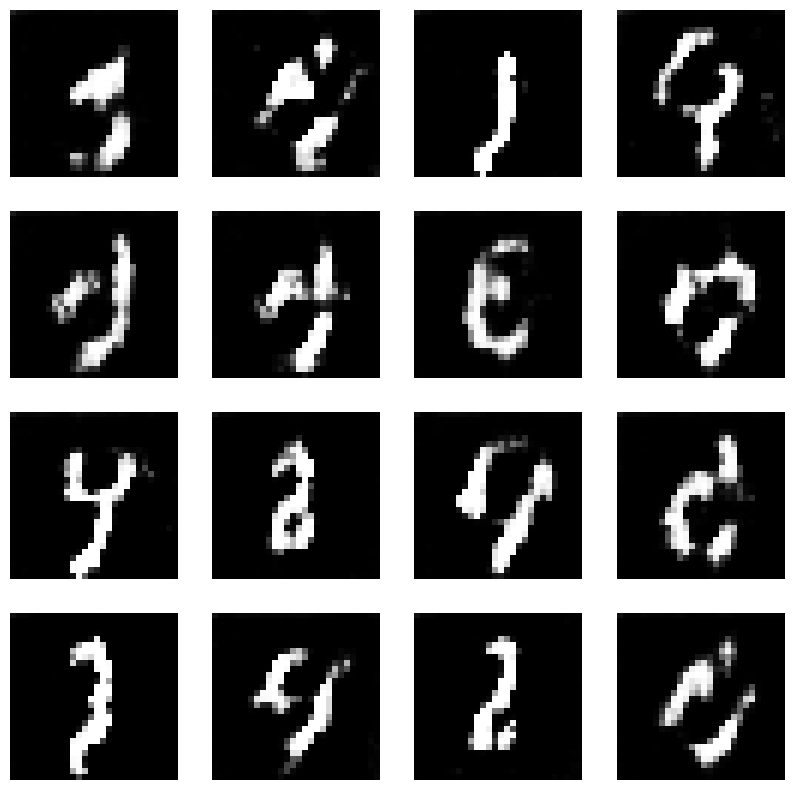

Epoch:  54


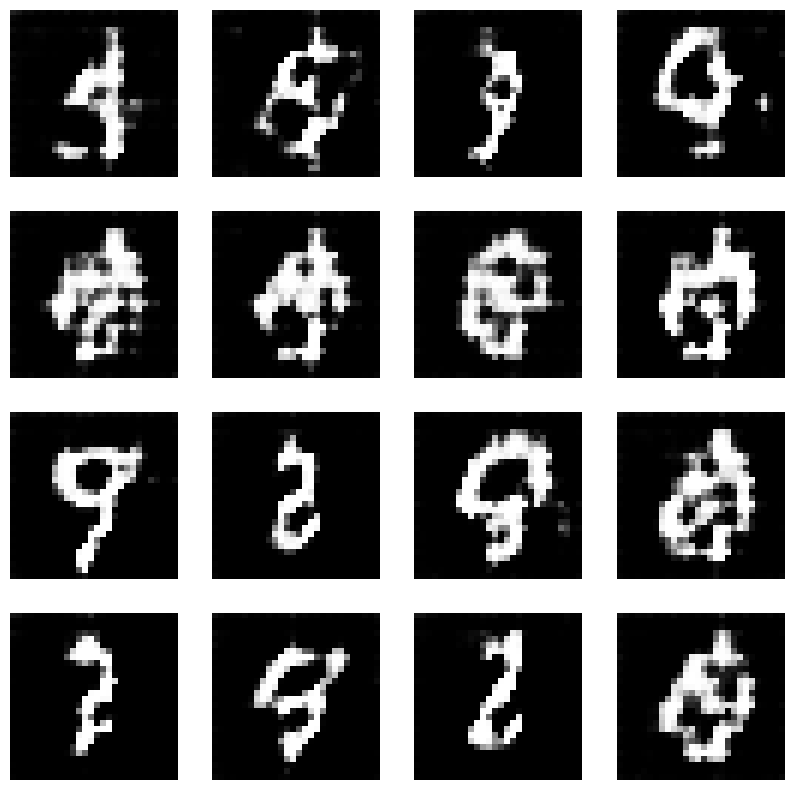

Epoch:  55


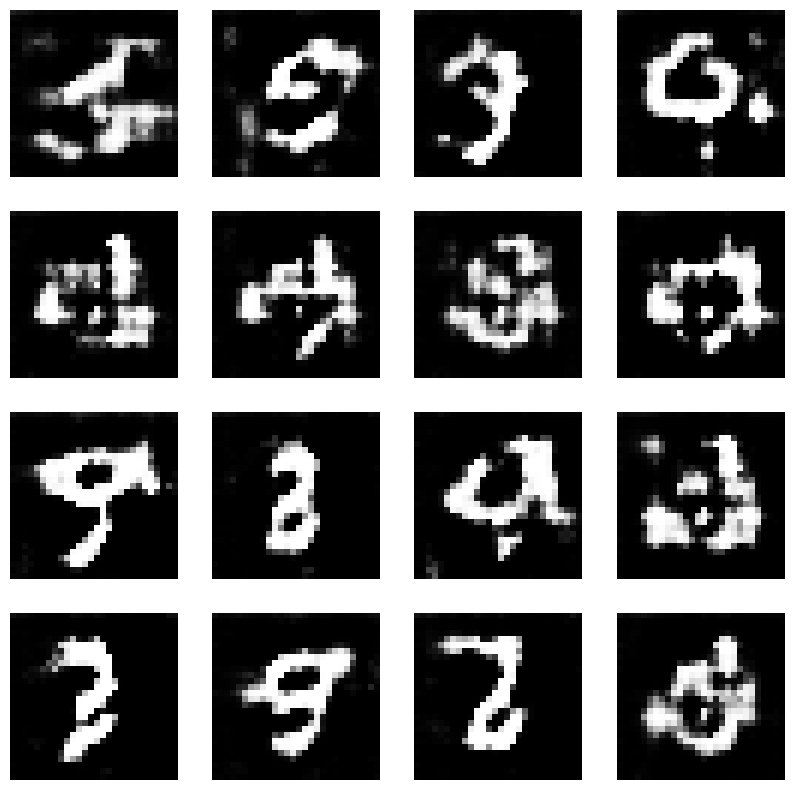

Epoch:  56


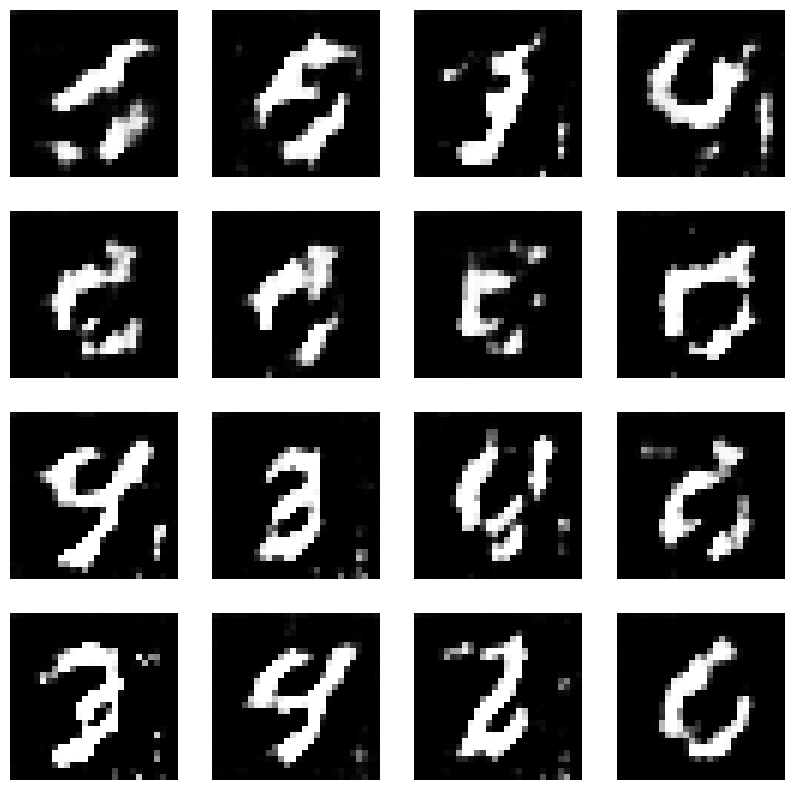

Epoch:  57


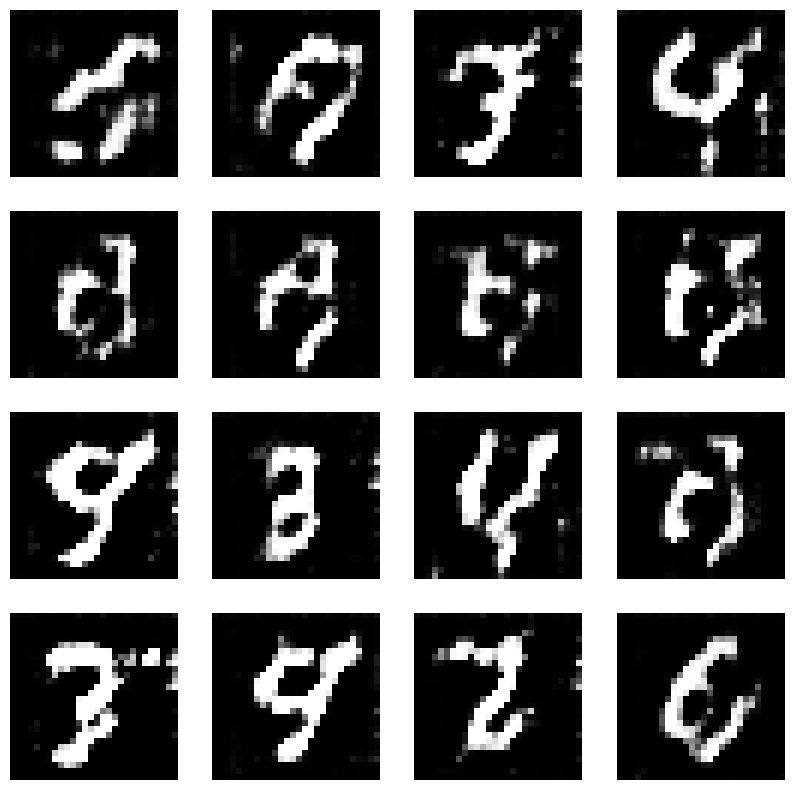

Epoch:  58


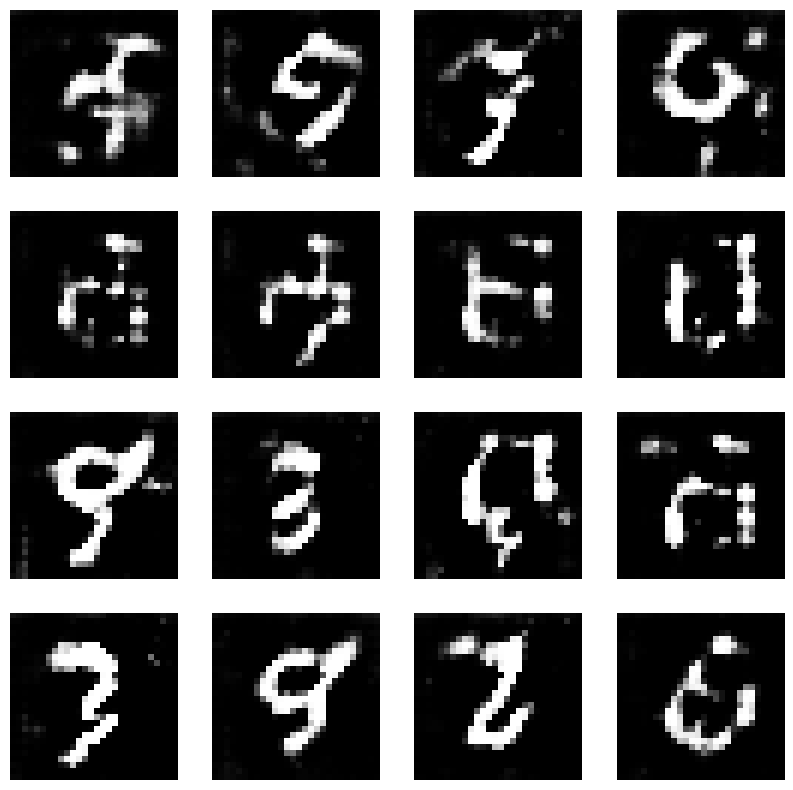

Epoch:  59


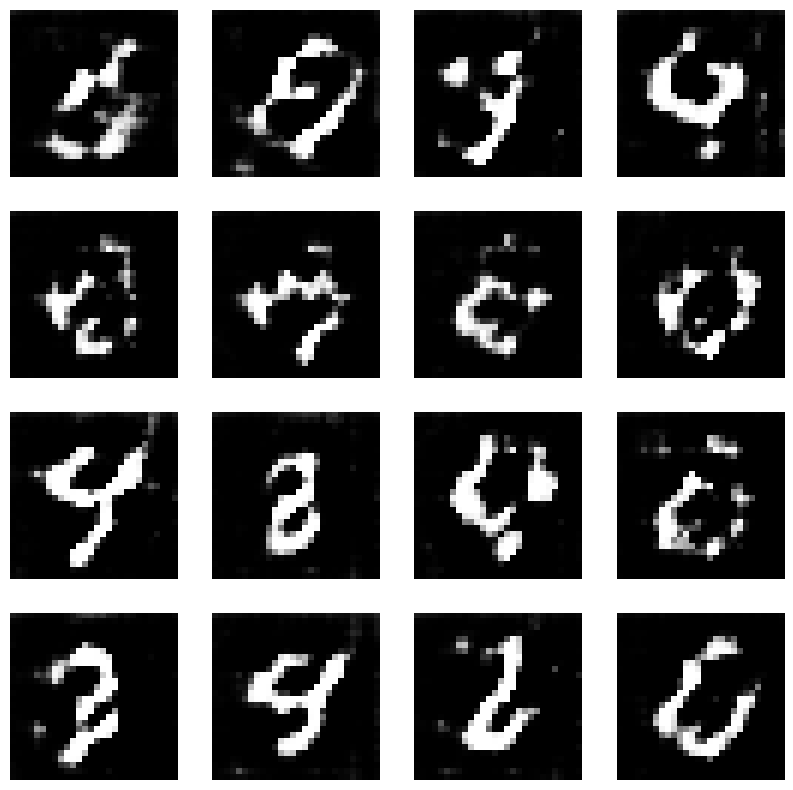

Epoch:  60


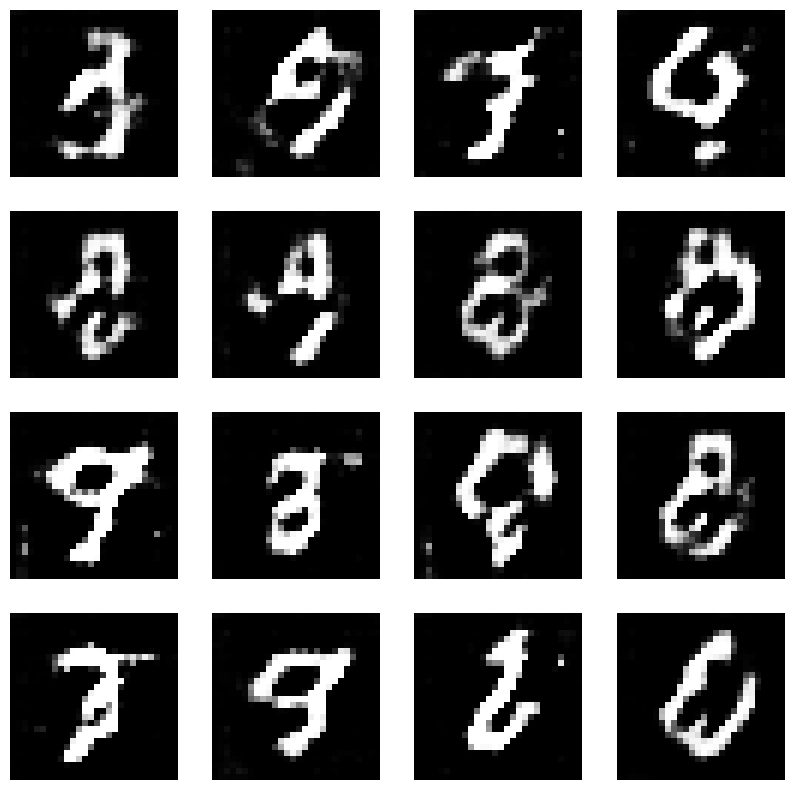

Epoch:  61


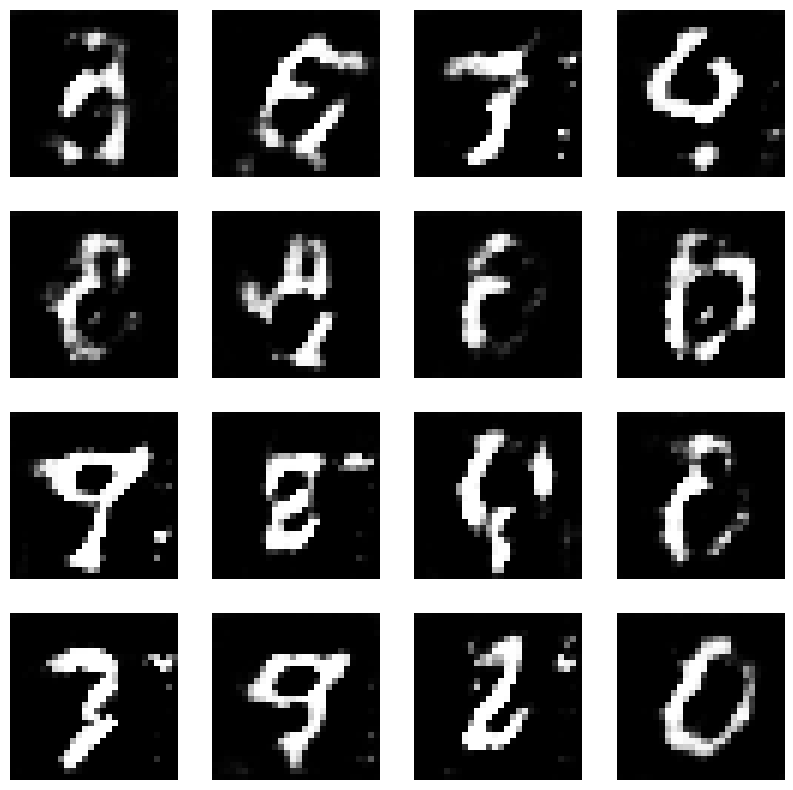

Epoch:  62


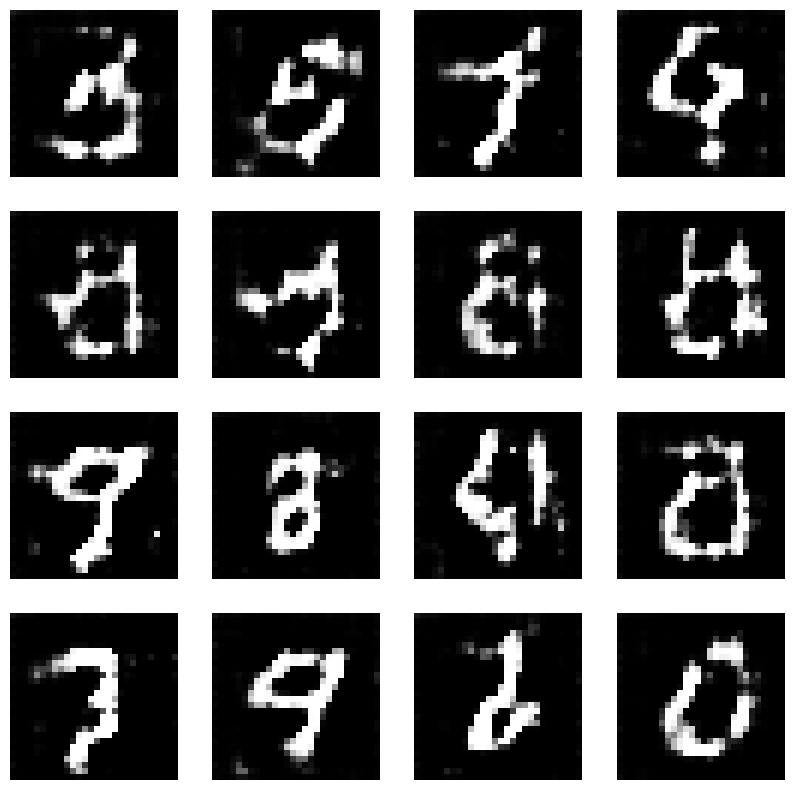

Epoch:  63


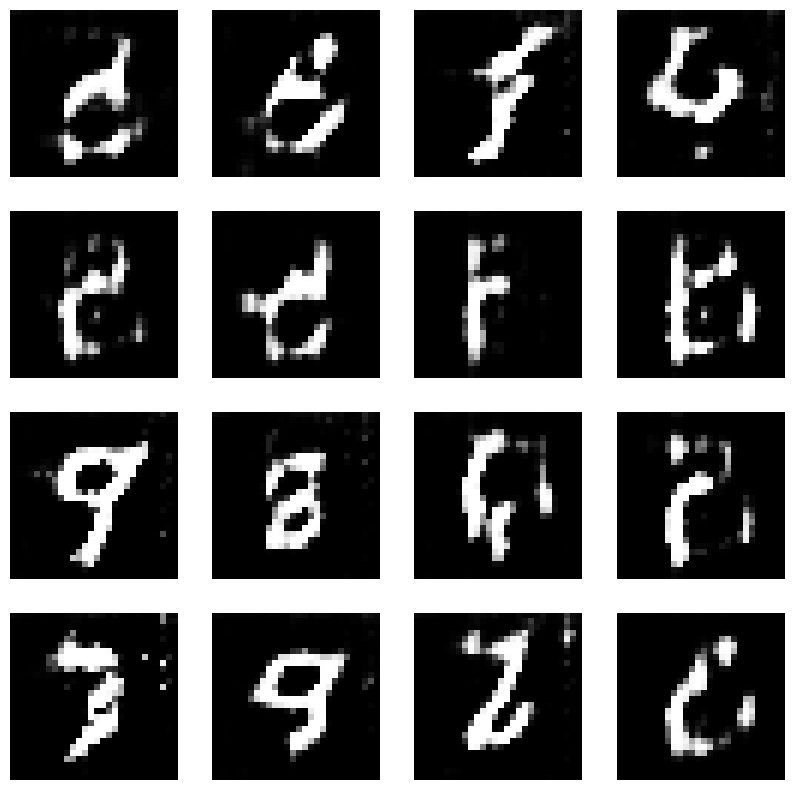

Epoch:  64


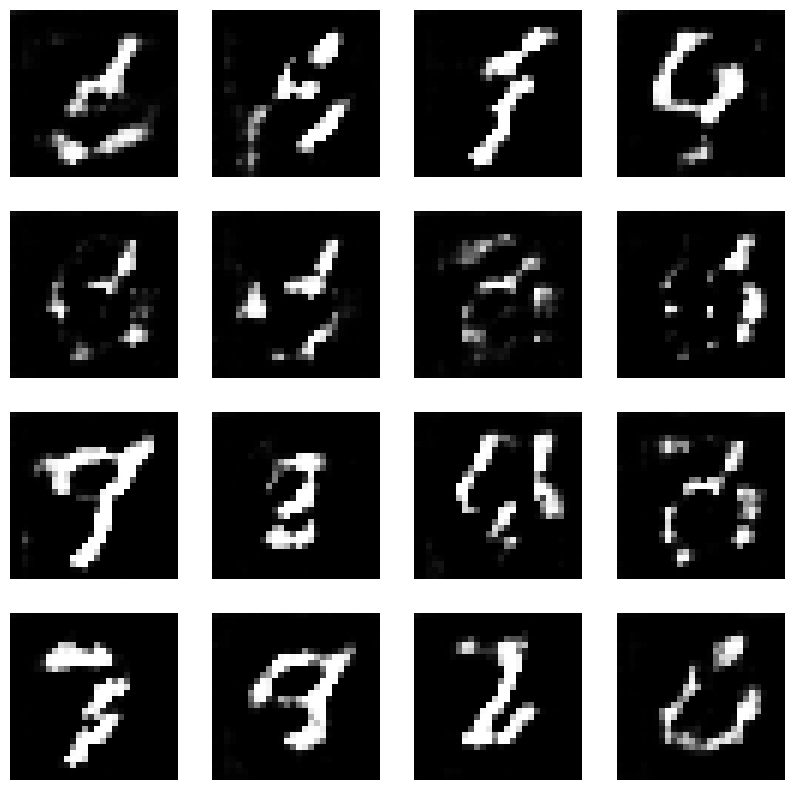

Epoch:  65


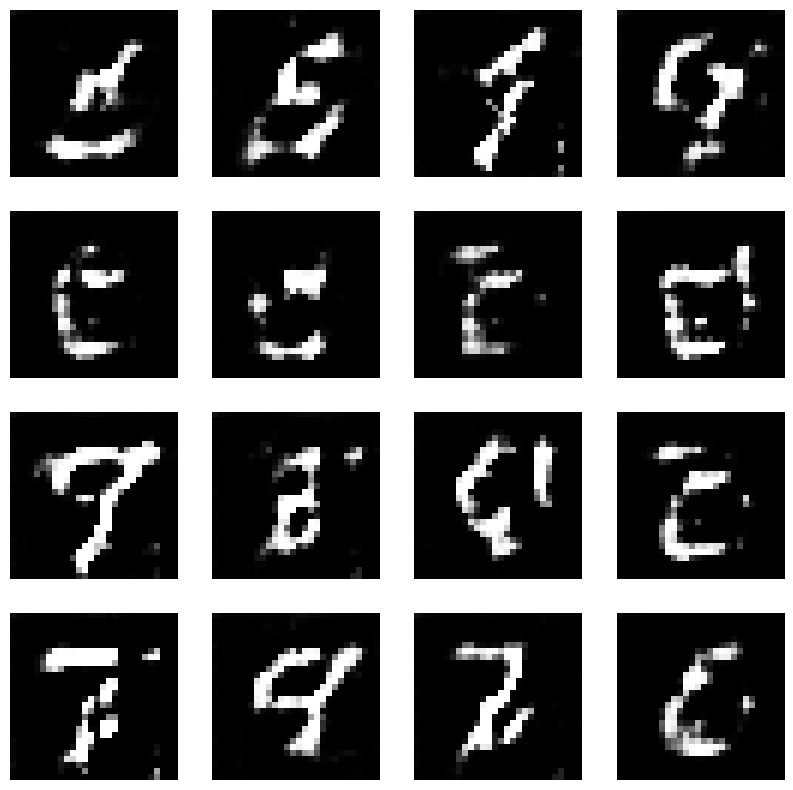

Epoch:  66


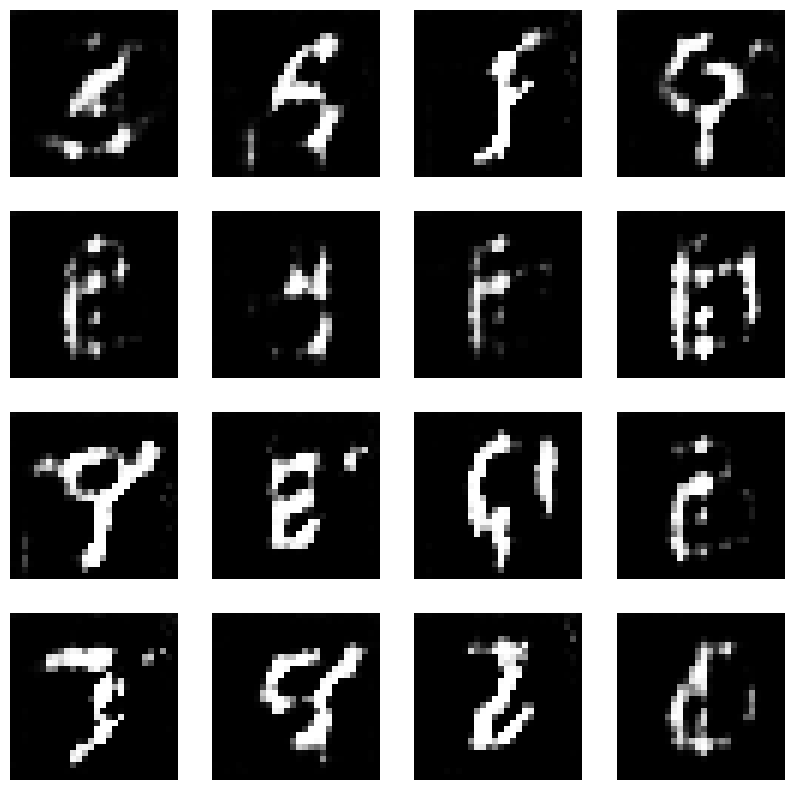

Epoch:  67


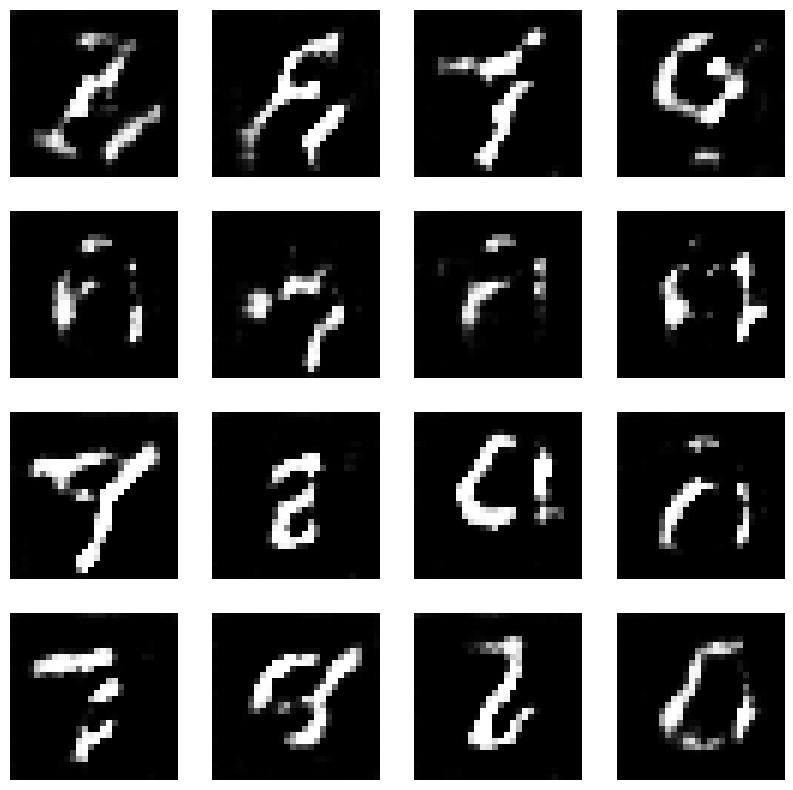

Epoch:  68


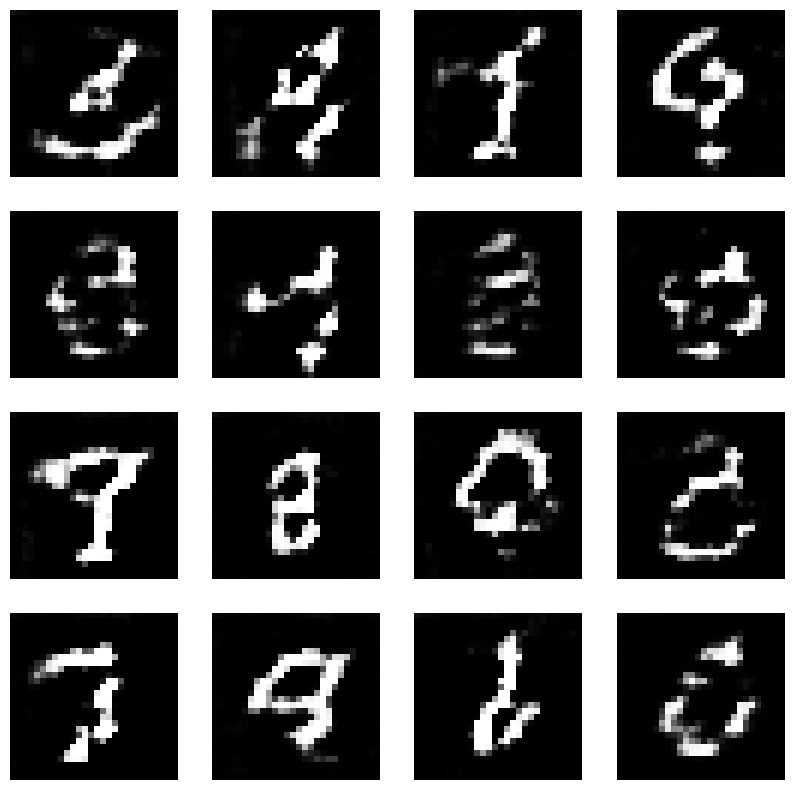

Epoch:  69


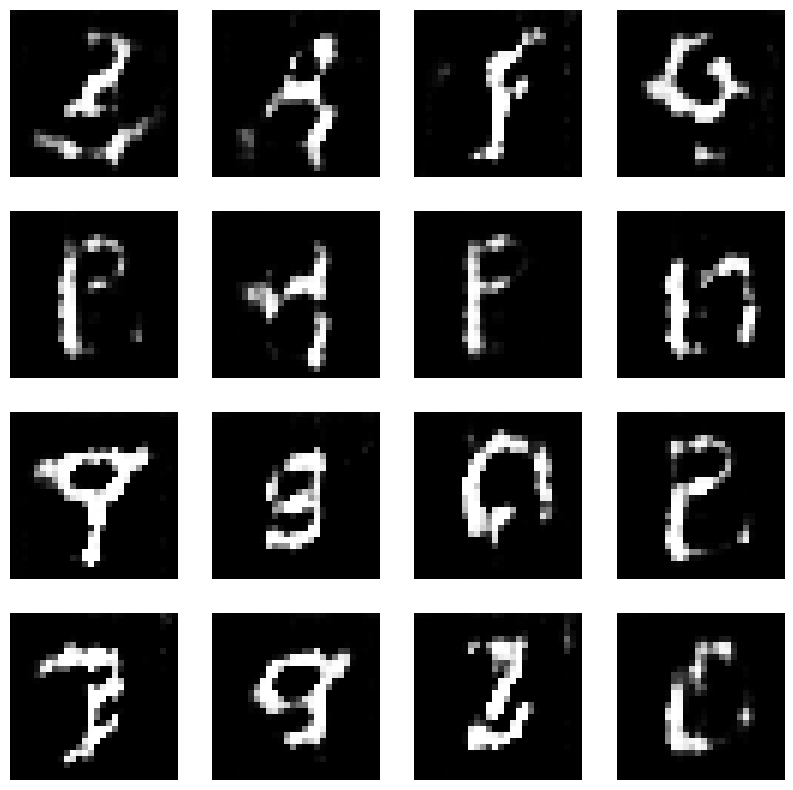

Epoch:  70


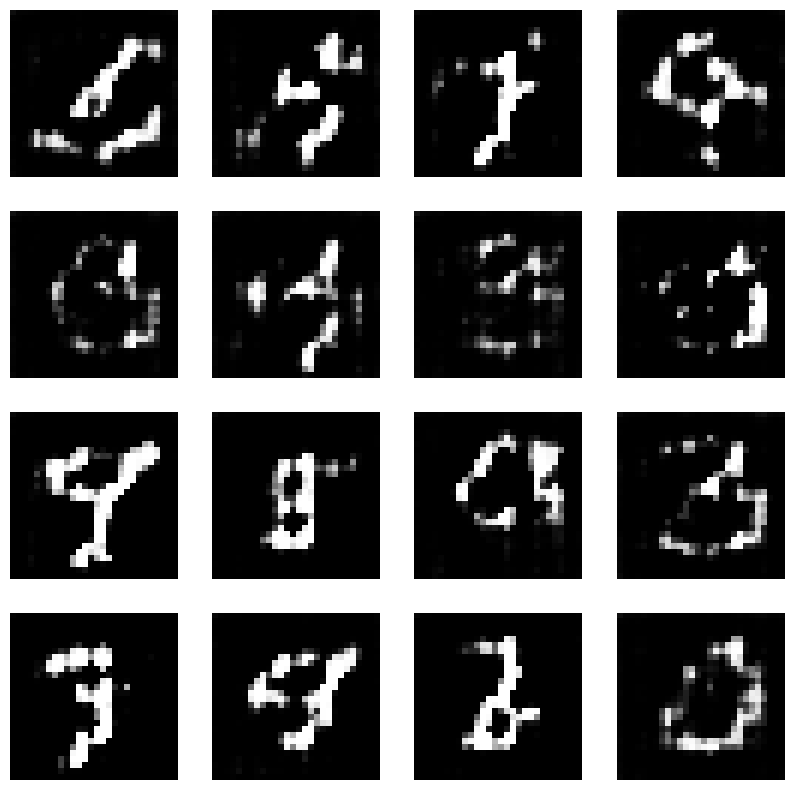

Epoch:  71


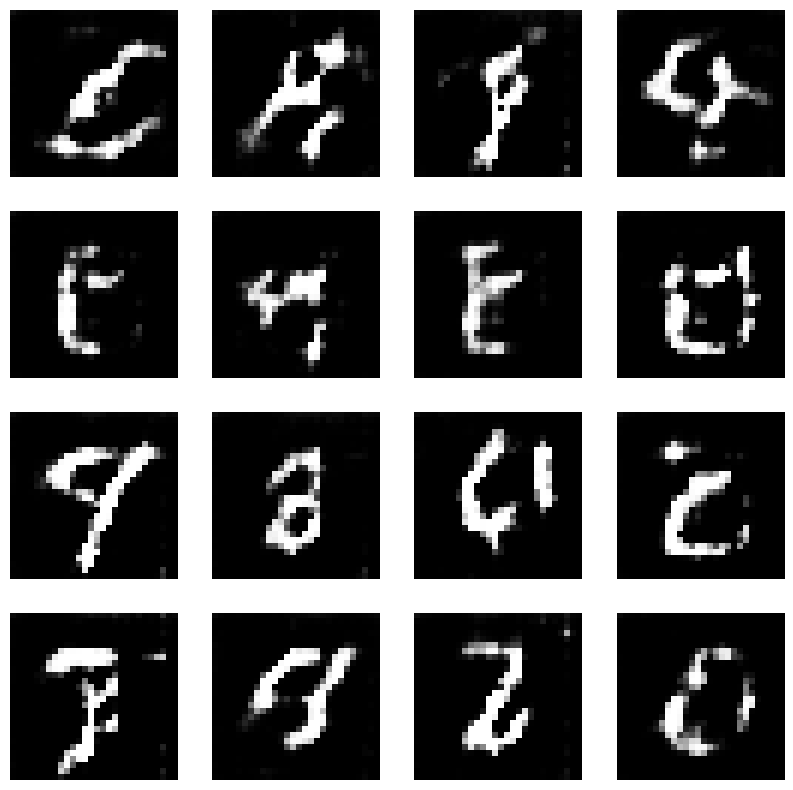

Epoch:  72


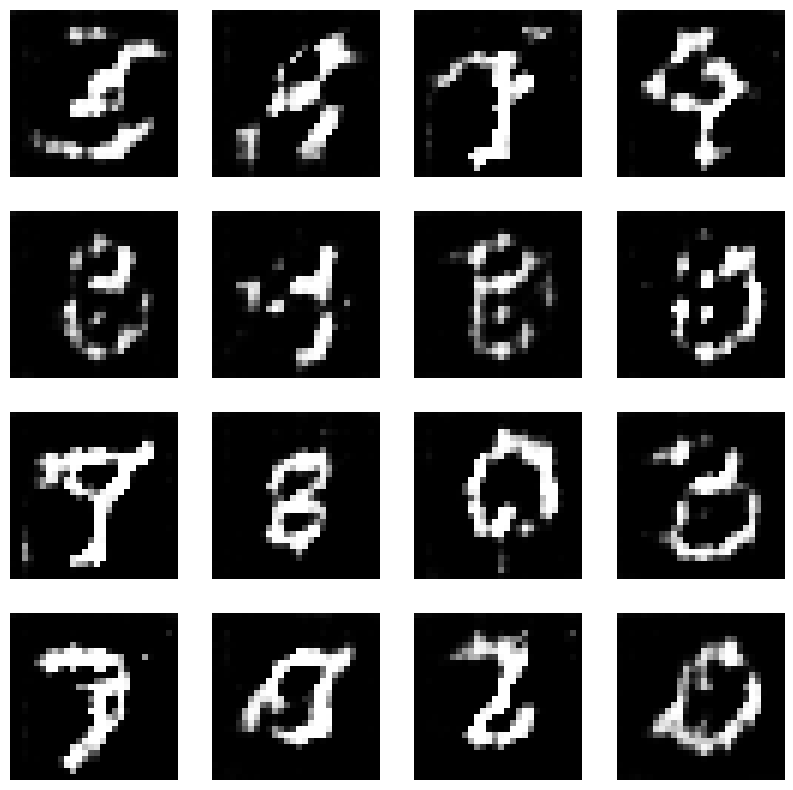

Epoch:  73


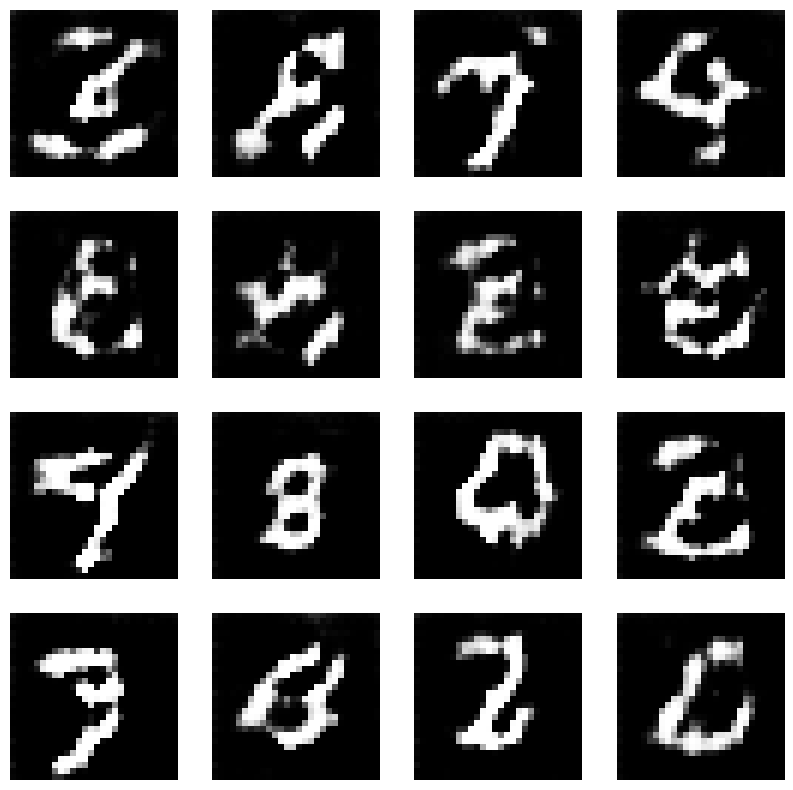

Epoch:  74


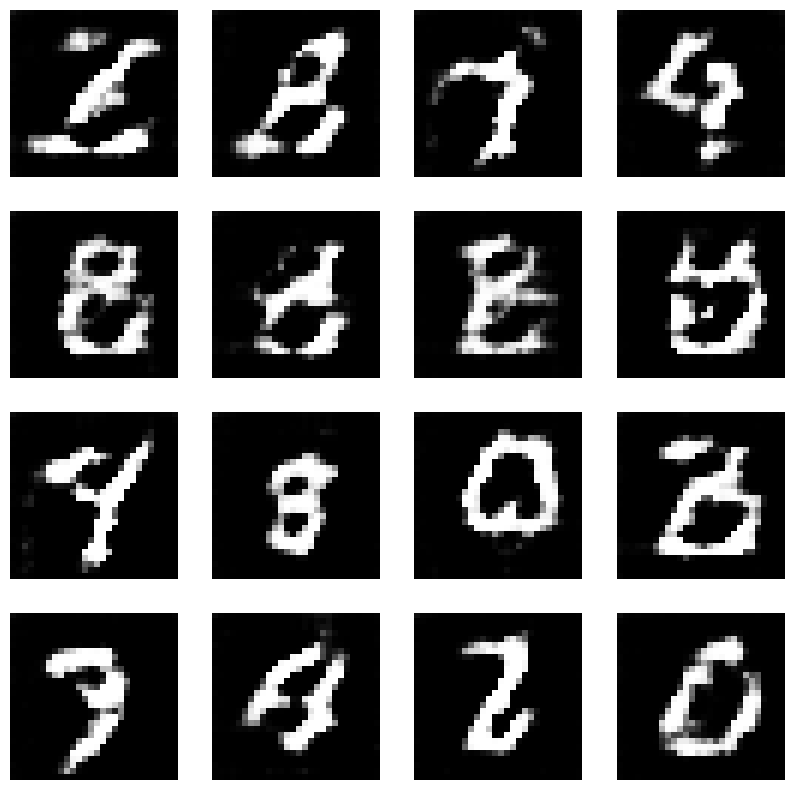

Epoch:  75


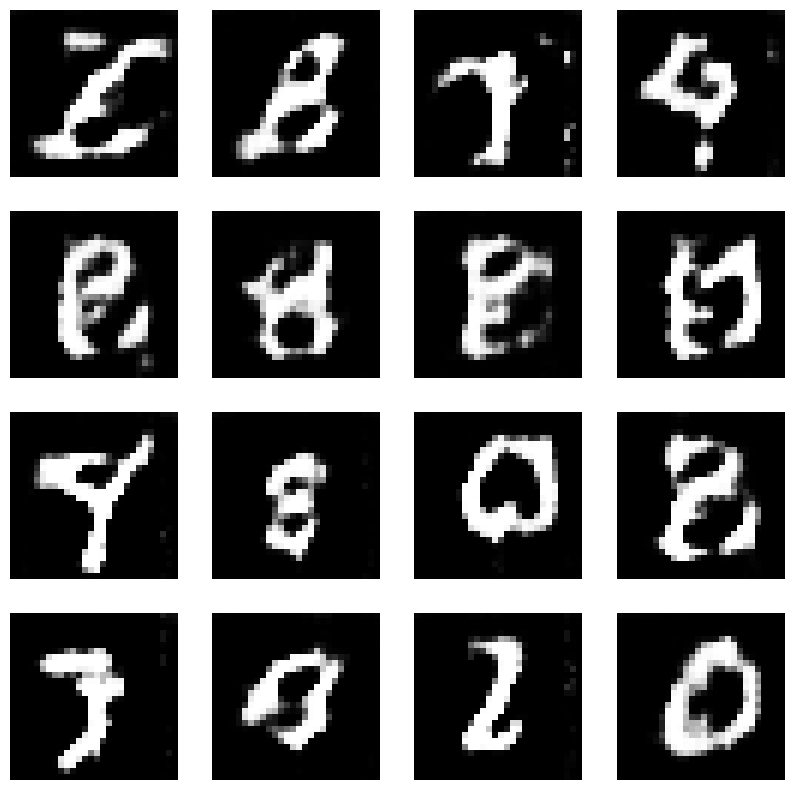

Epoch:  76


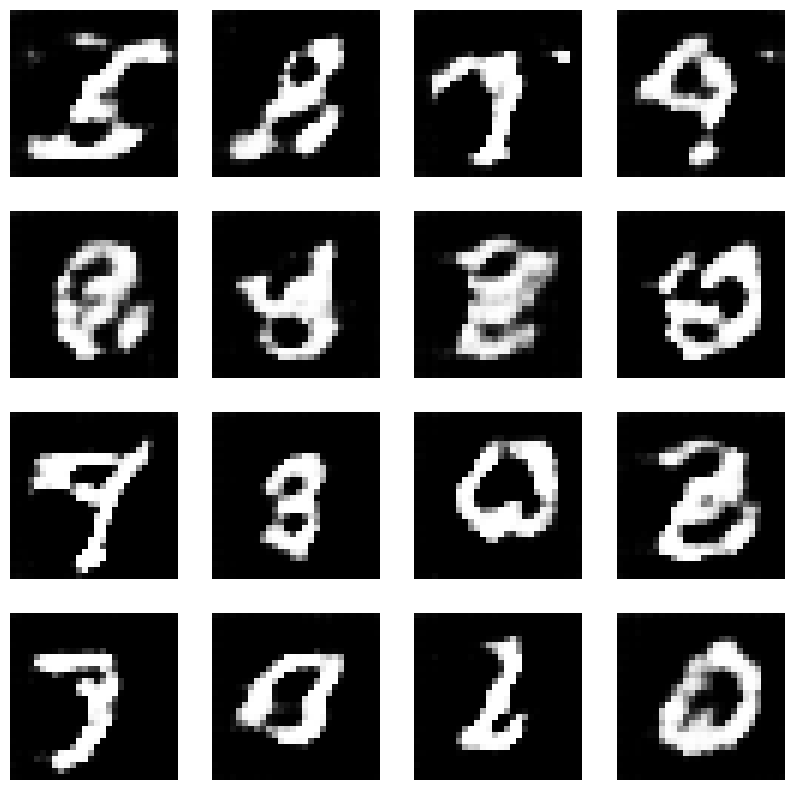

Epoch:  77


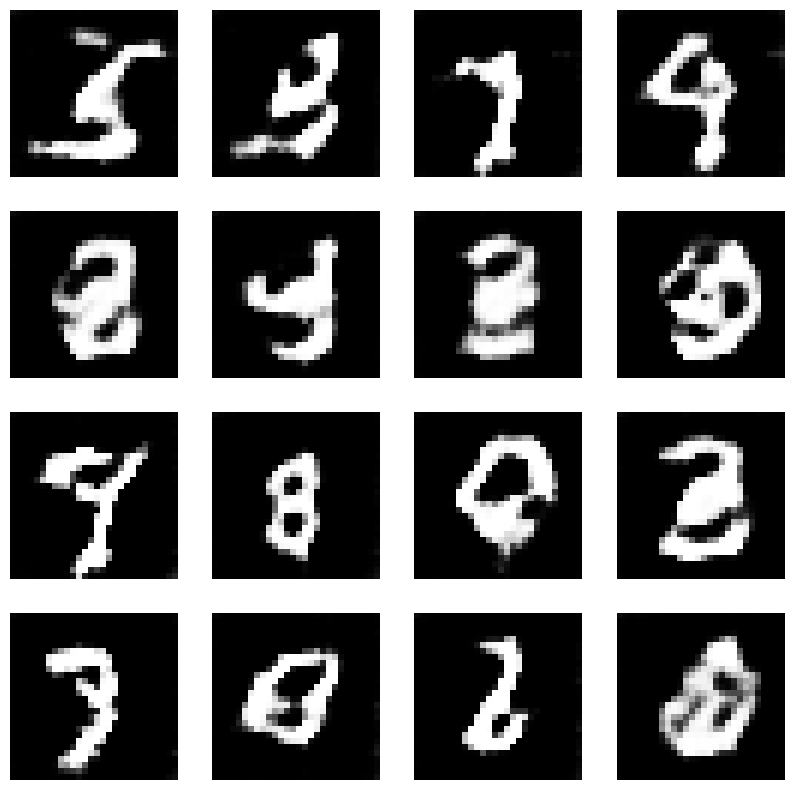

Epoch:  78


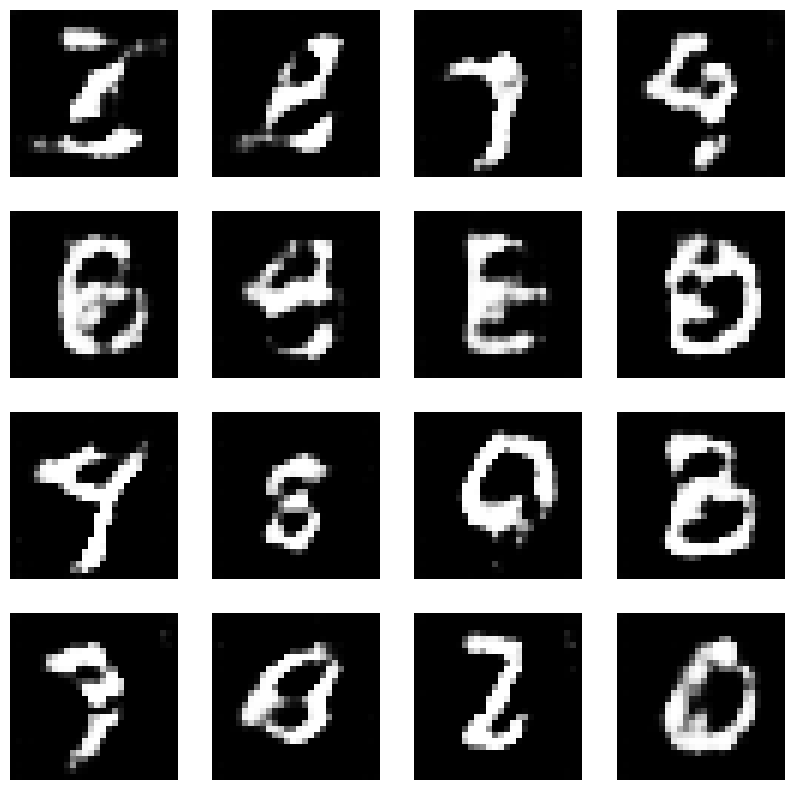

Epoch:  79


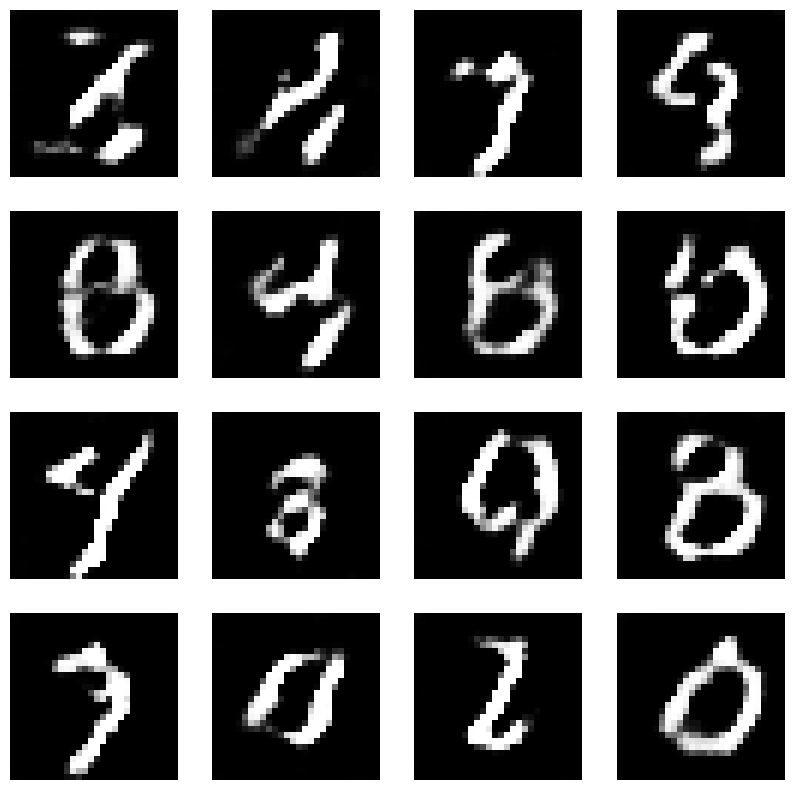

Epoch:  80


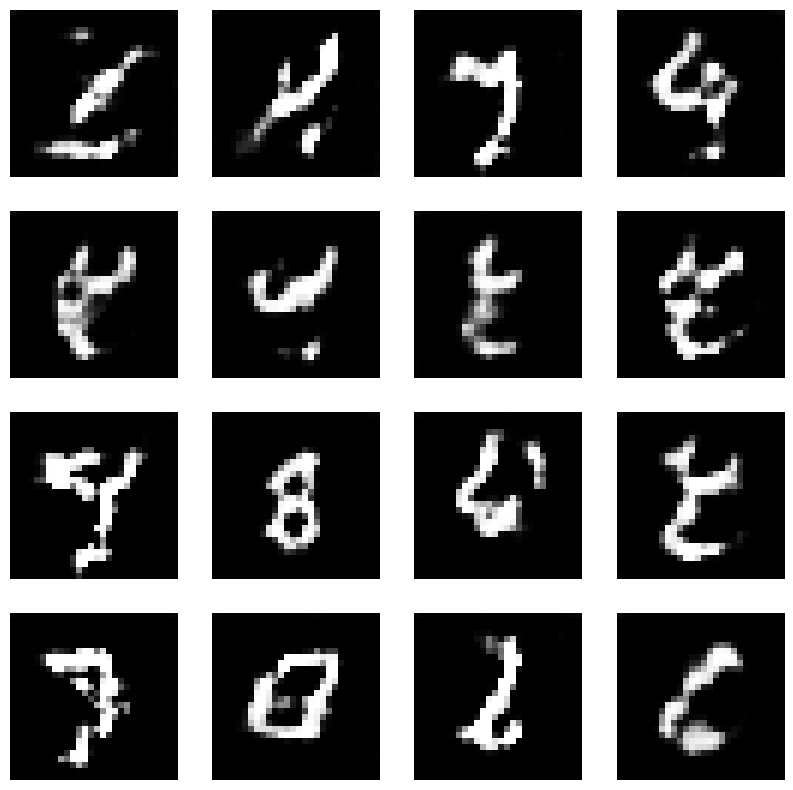

Epoch:  81


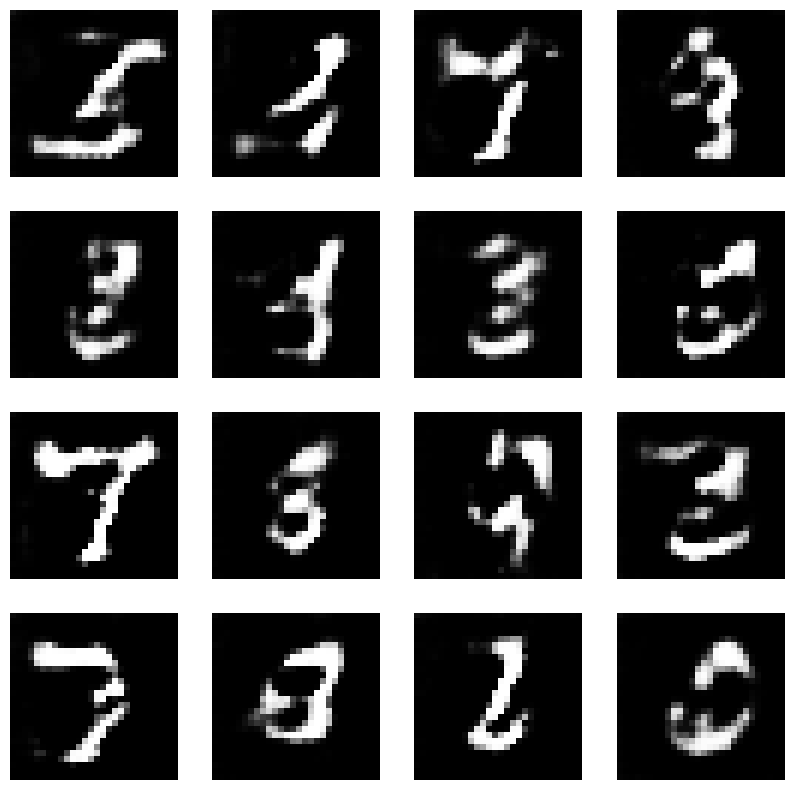

Epoch:  82


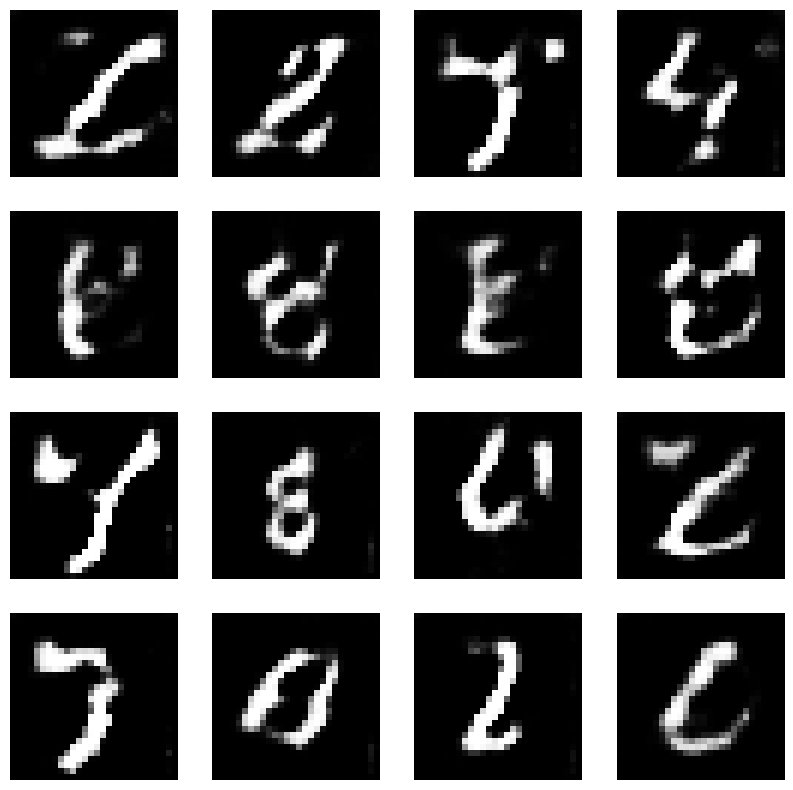

Epoch:  83


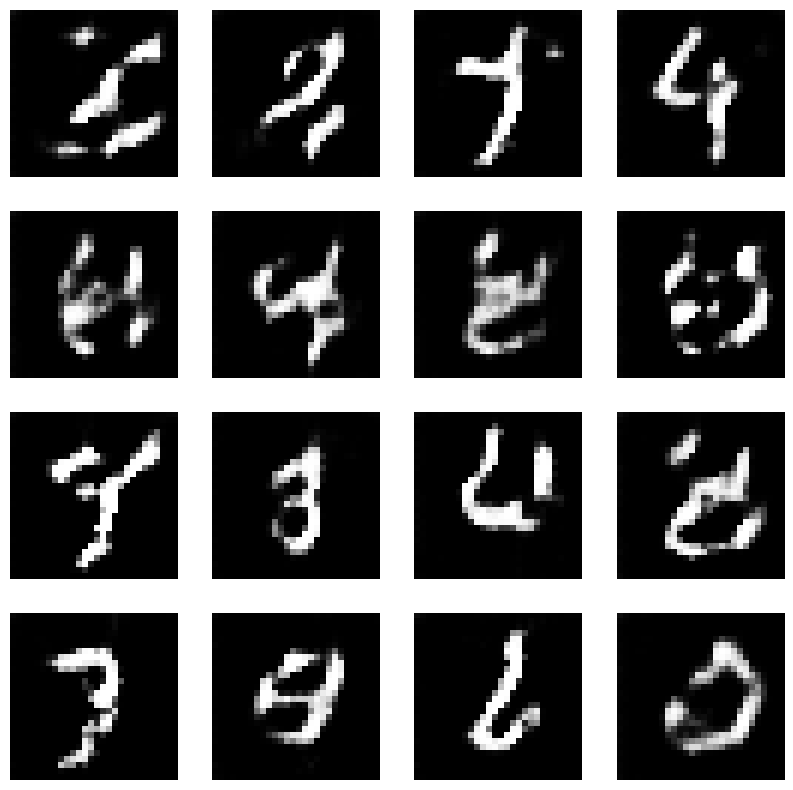

Epoch:  84


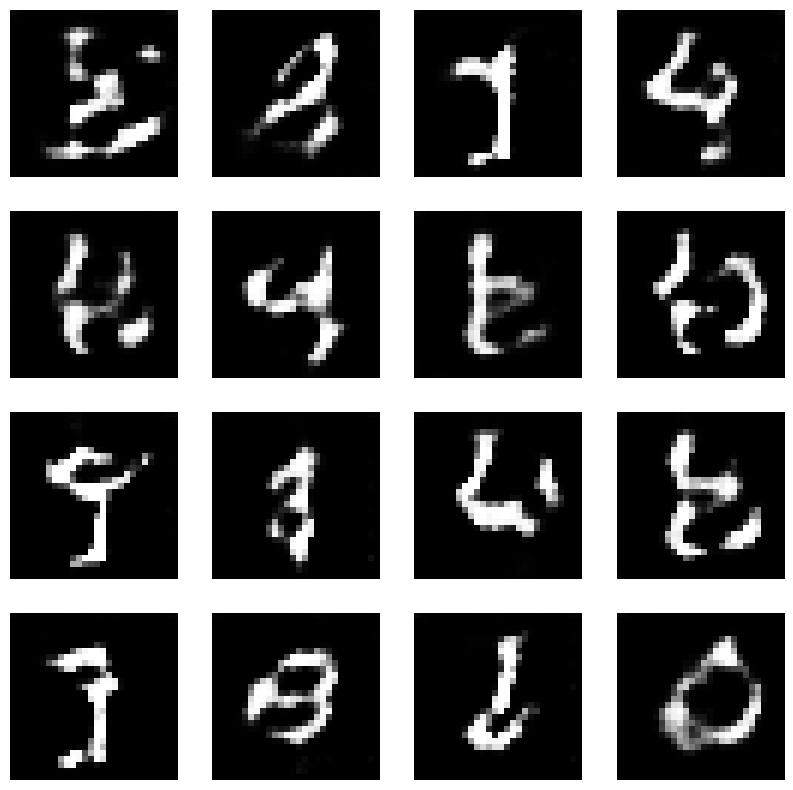

Epoch:  85


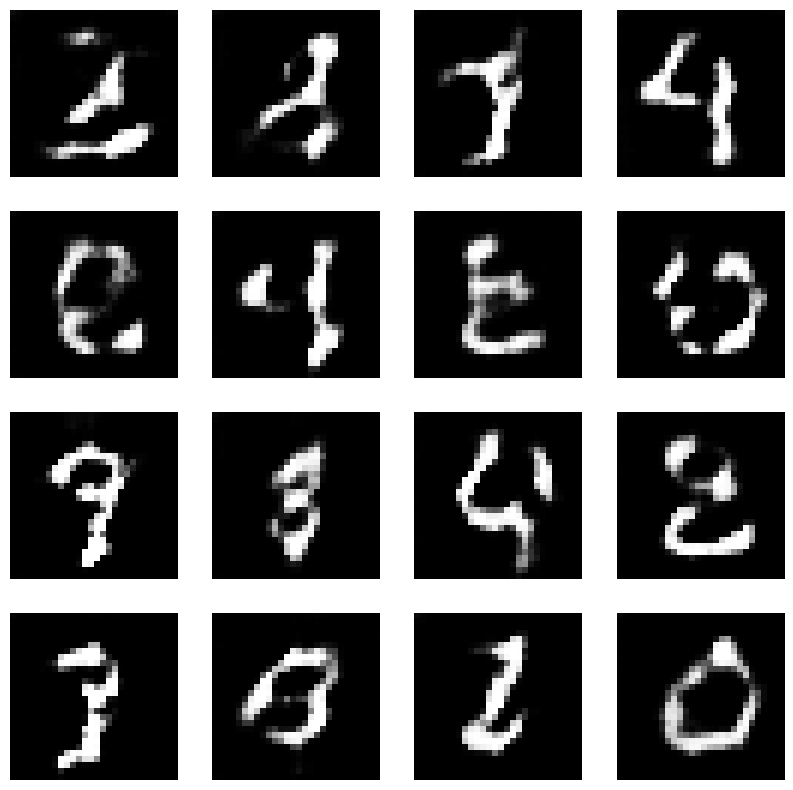

Epoch:  86


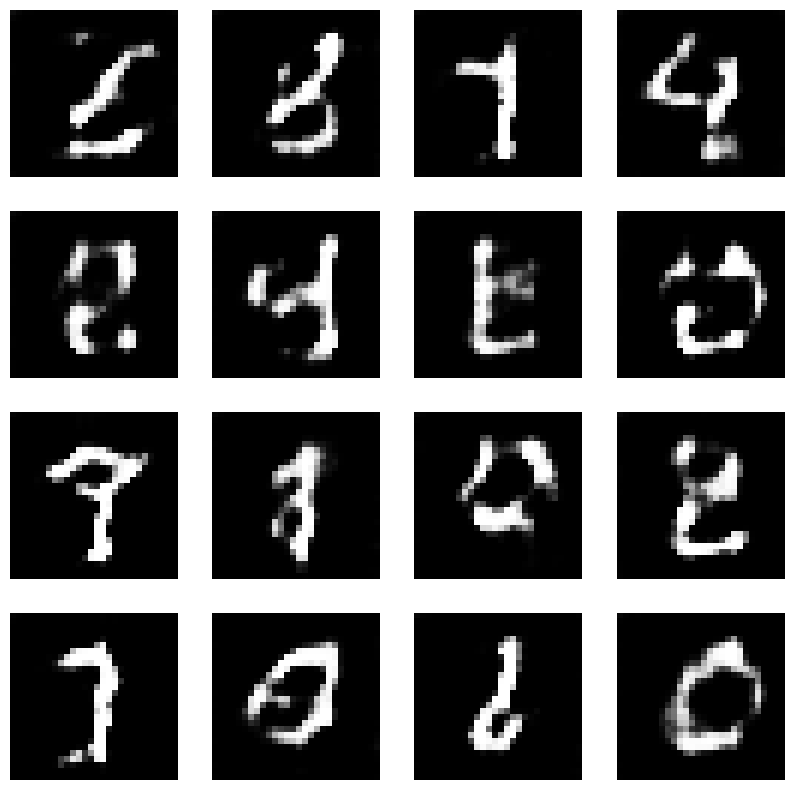

Epoch:  87


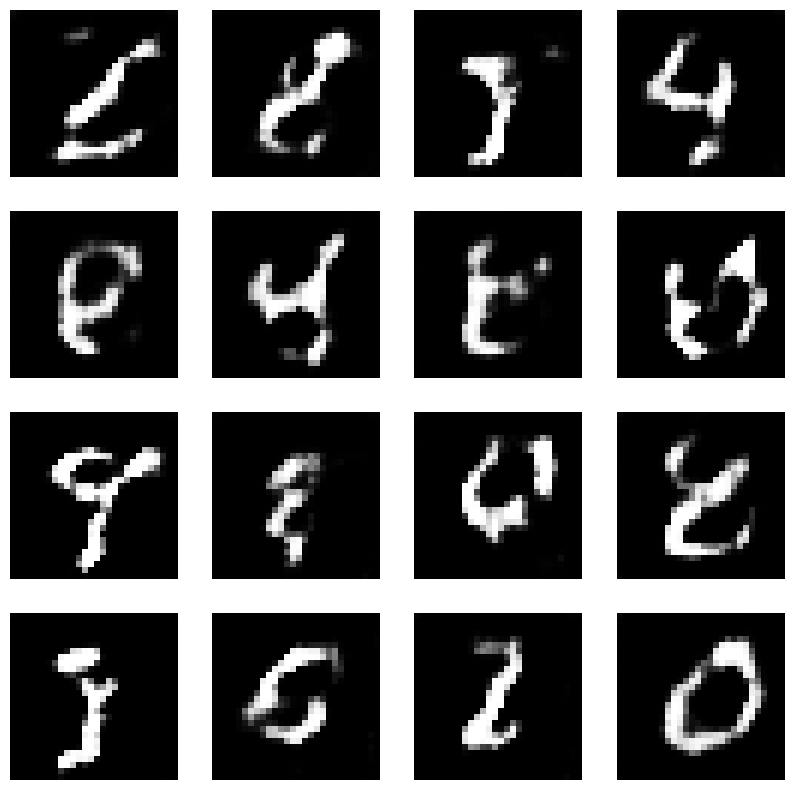

Epoch:  88


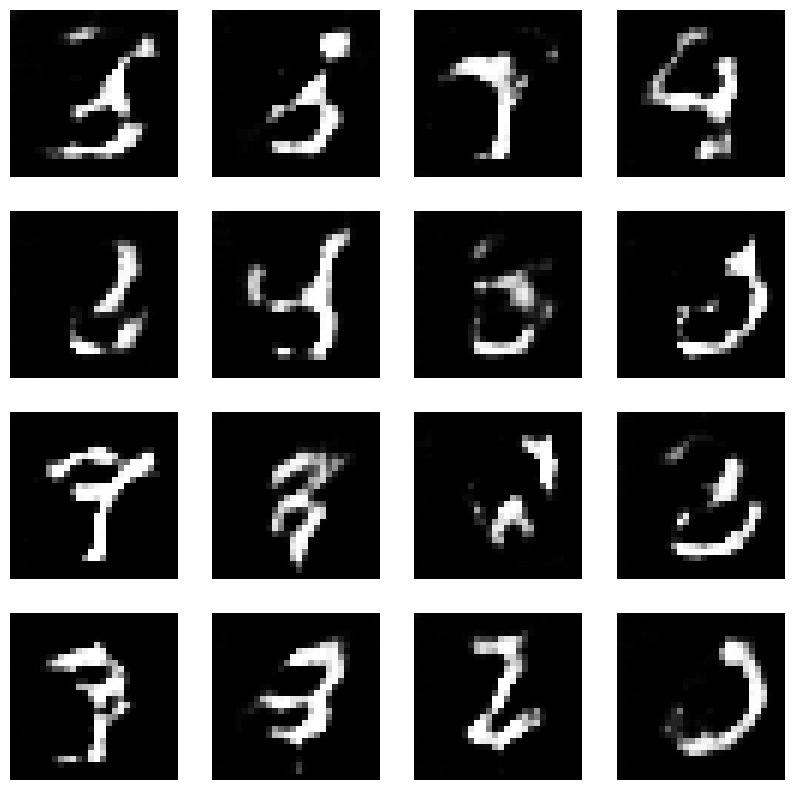

Epoch:  89


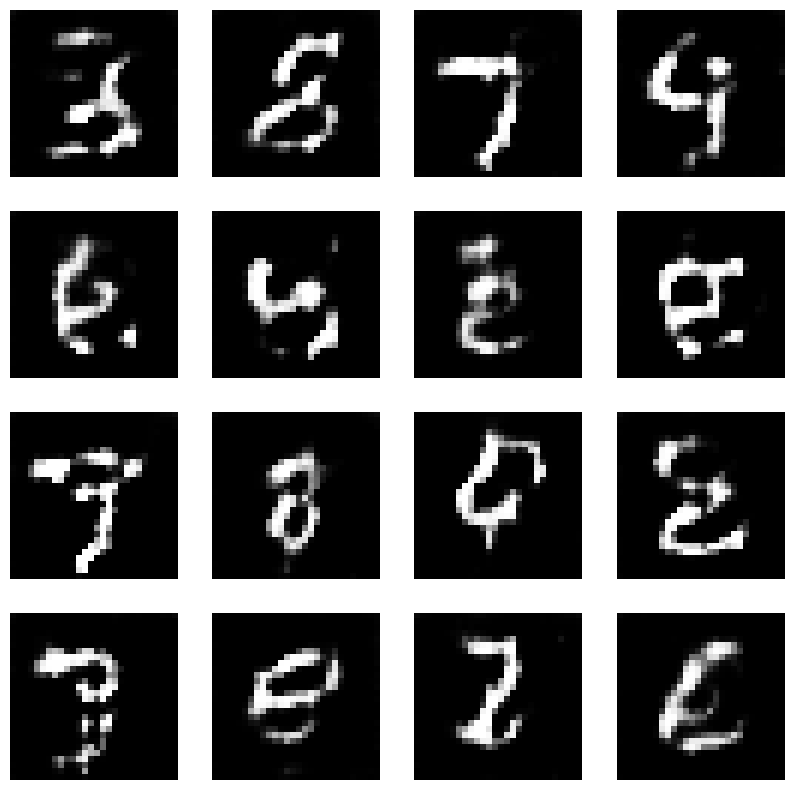

Epoch:  90


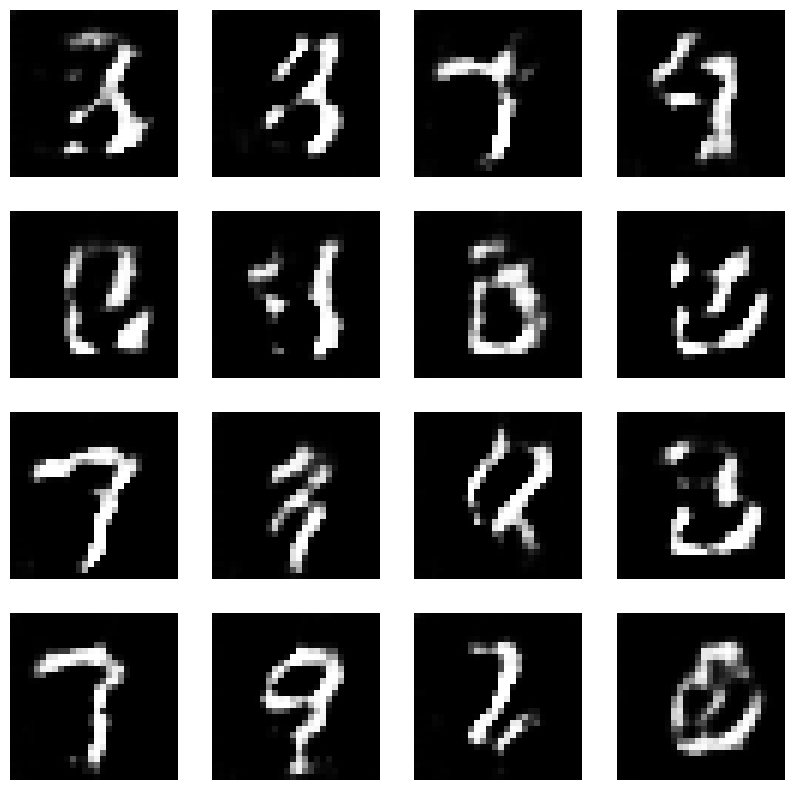

Epoch:  91


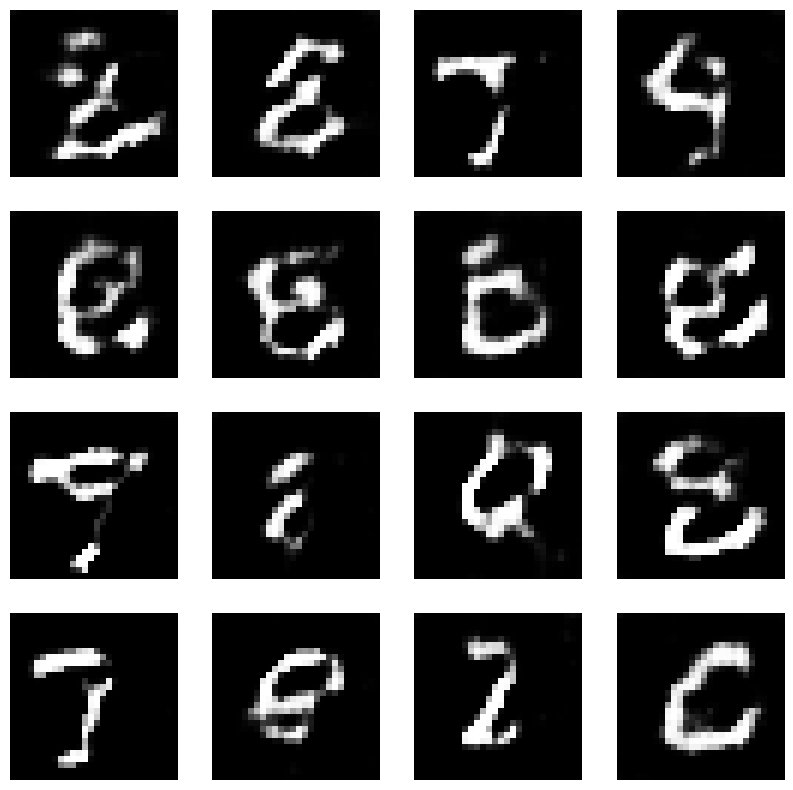

Epoch:  92


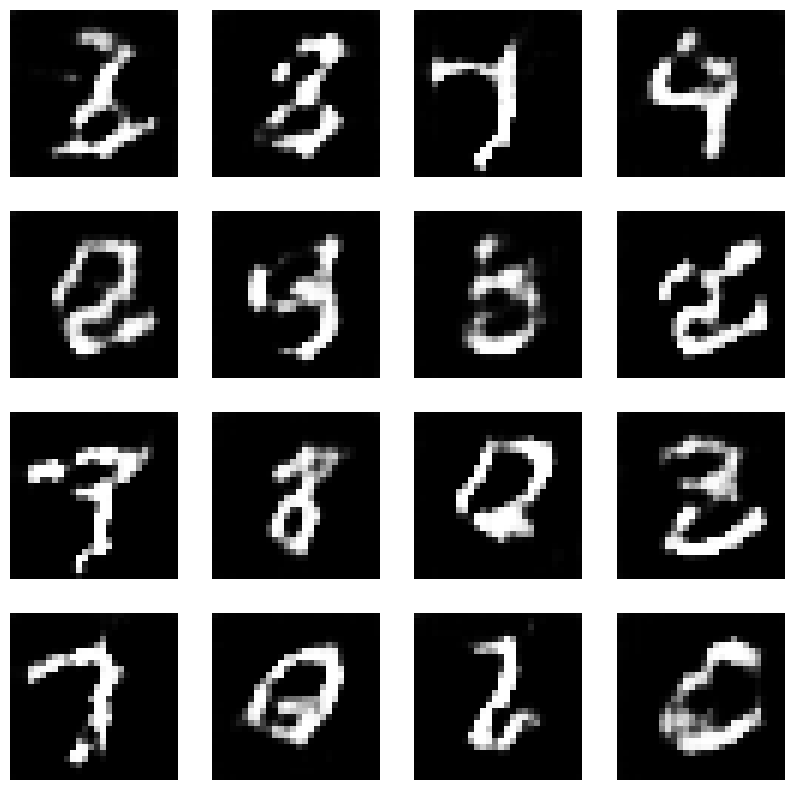

Epoch:  93


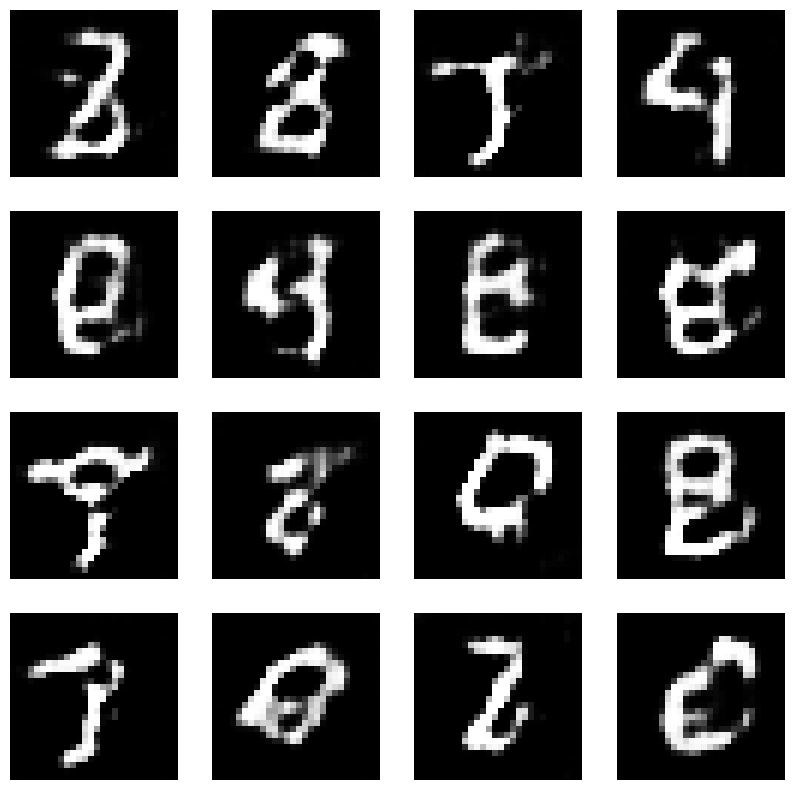

Epoch:  94


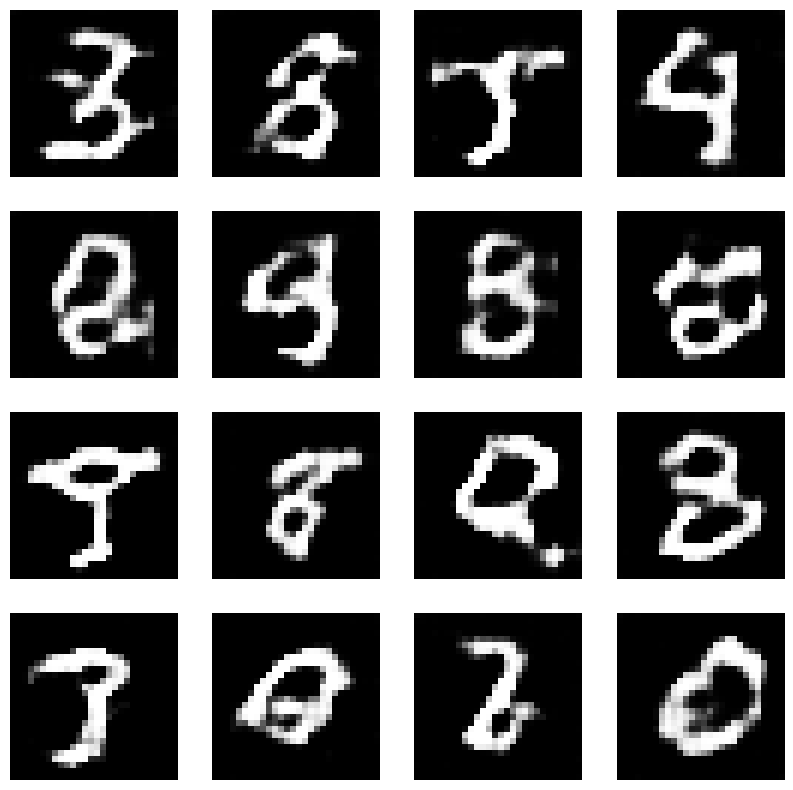

Epoch:  95


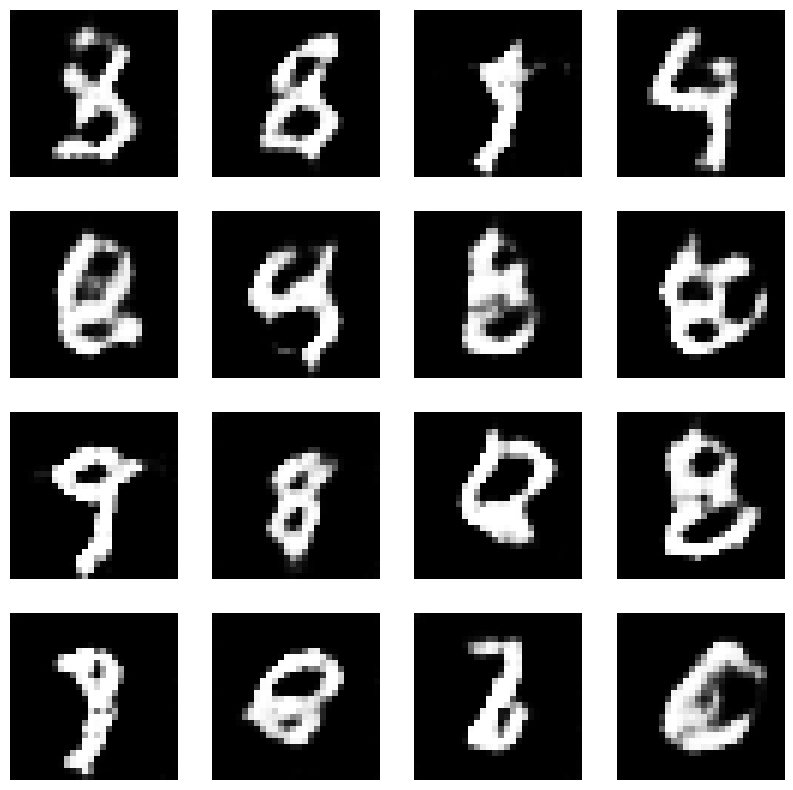

Epoch:  96


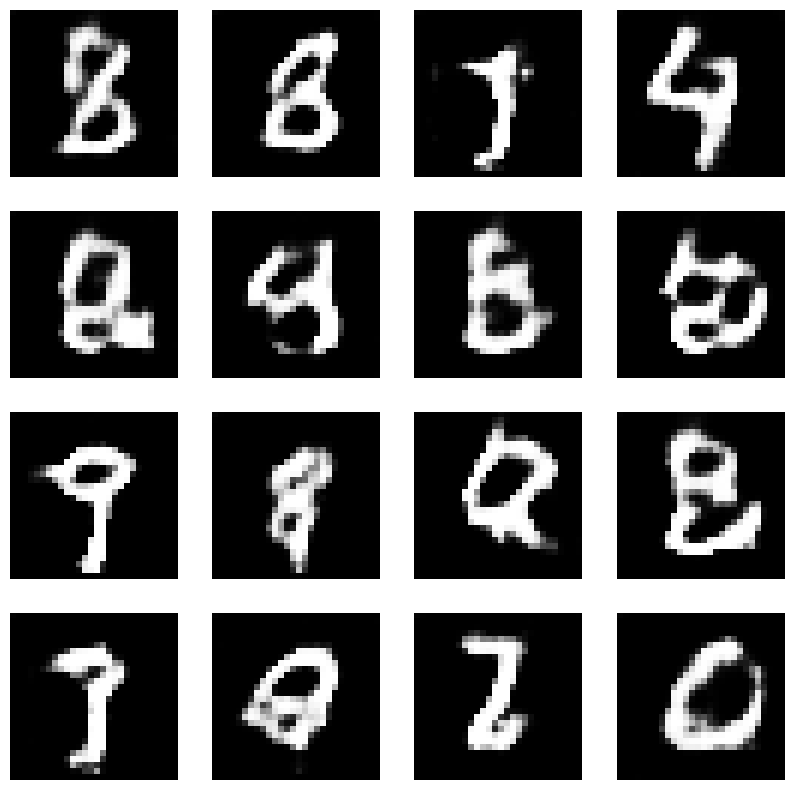

Epoch:  97


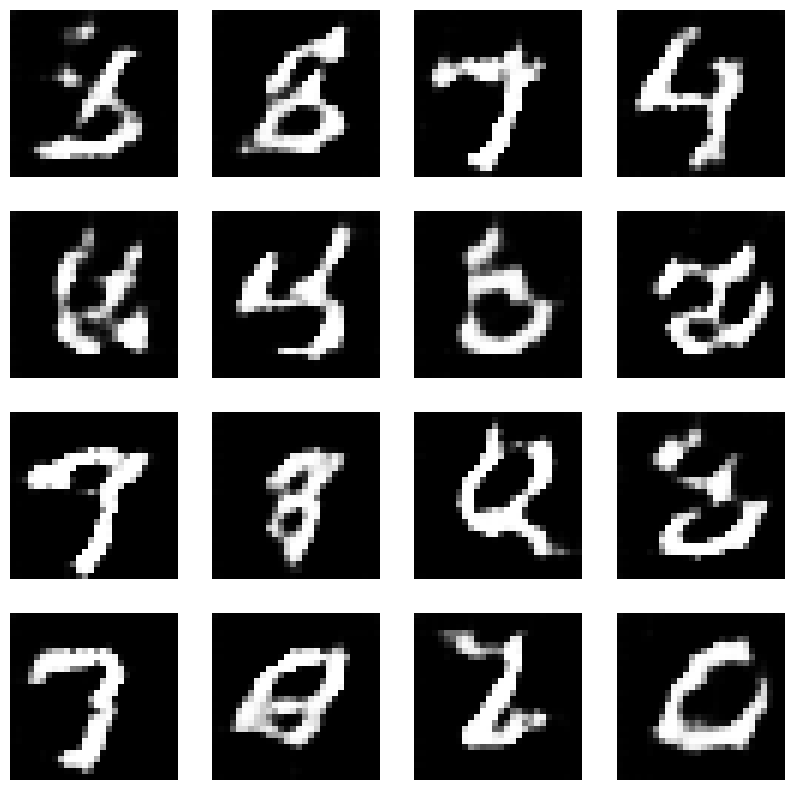

Epoch:  98


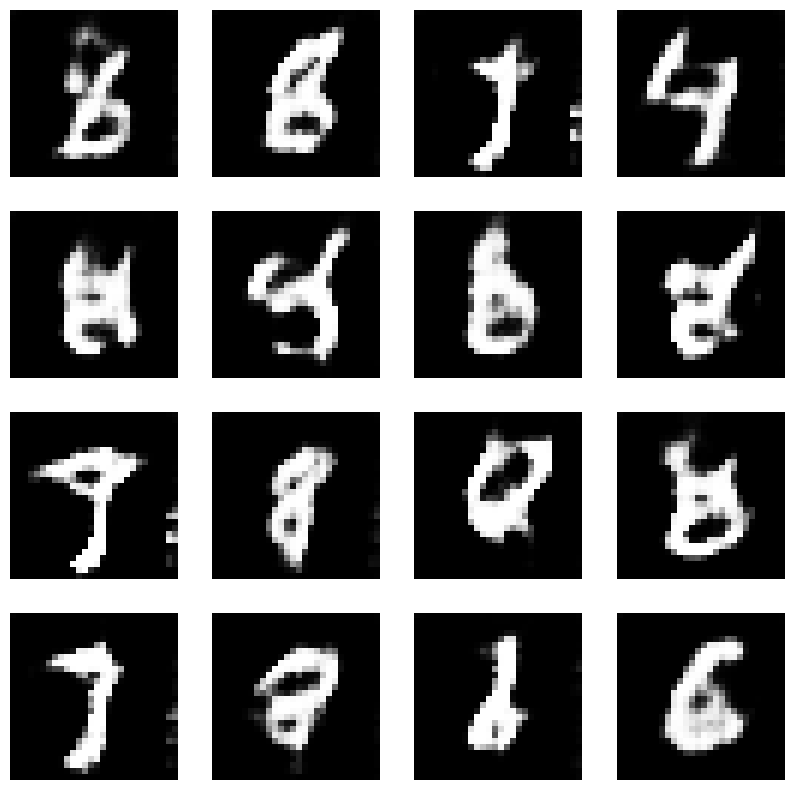

Epoch:  99


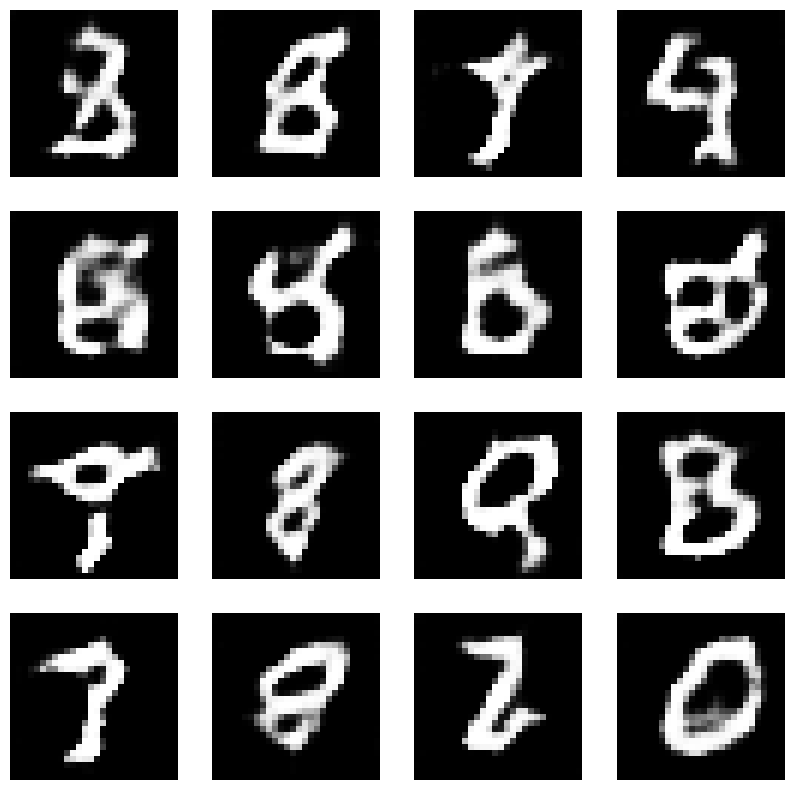

Epoch:  100


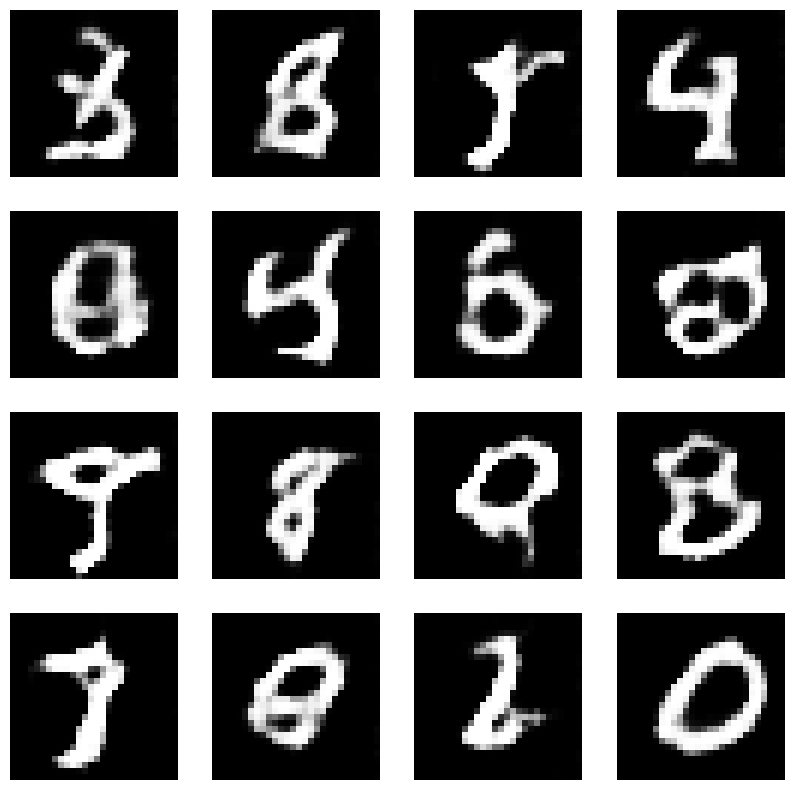

In [ ]:
train_gan(xtrain, epochs, test_images)